# Load library

In [2]:
# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))

import xai_faithfulness_experiments_lib_edits as fl

## Load data

In [3]:
import numpy as np

filename = 'avila_250_measures-1M.npz'
data = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', filename))

qmeans = data['qmeans'][:1000001] # Only for 1M file
qmeans_bas = data['qmean_bas'][:1000001]
qmean_invs = data['qmean_invs'][:1000001]

## Evaluating the metrics
Measure how good each of the metrics is at determining how exceptional a given ranking is.

The ground truth will be the z-score for each ranking. To determine it, one must model the distribution of all possible rankings, which is unfeasible in most cases but we can do here.

### Q-mean distribution

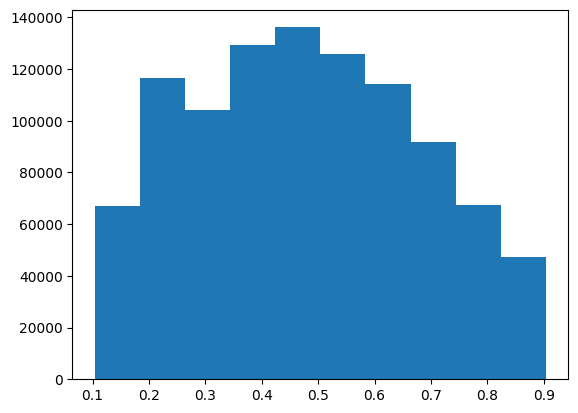

Avg:0.47790536284446716 | Std:0.20171046257019043


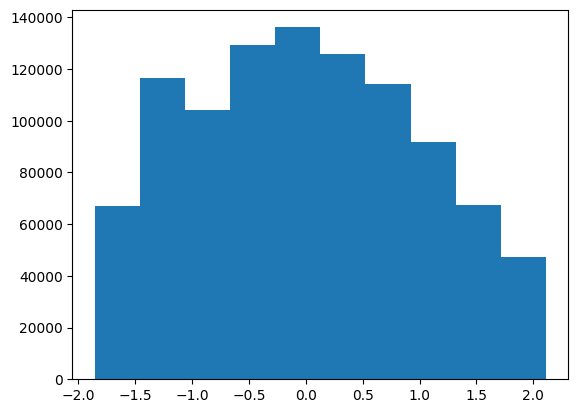

In [38]:
import matplotlib.pyplot as plt

plt.hist(qmeans, bins=10)
plt.show()


qmean_mean = np.mean(qmeans)
qmean_std = np.std(qmeans)

z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()

print(f'Avg:{qmean_mean} | Std:{qmean_std}')
plt.hist(z_scores, bins=10)
plt.show()

(12866,)


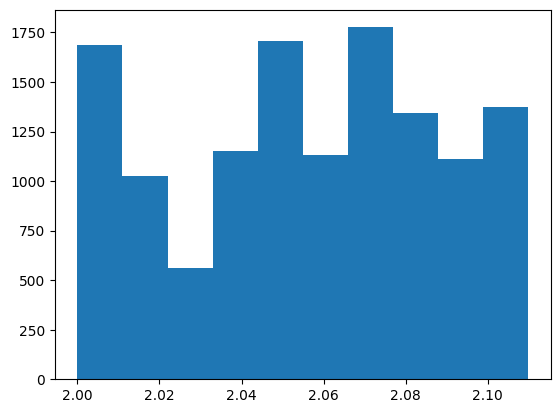

In [77]:
# Stratify z-index to be able to compare performance on different parts of the spectrum
indices = np.arange(z_scores.shape[0])

z_scores_numbered = np.vstack((z_scores, indices))

level_indices = []
boundaries = [float('-inf'), 0, 0.5, 1, 1.5, 2]
for i in range(1,len(boundaries)+1):
    bottom_limit = boundaries[i-1]
    top_limit = float('inf')
    if i < len(boundaries):
        top_limit = boundaries[i]
    level_indices.append((z_scores_numbered[:,np.logical_and(bottom_limit<=z_scores, z_scores<top_limit)][1,:].astype(int),(bottom_limit, top_limit)))

exceptional_indices = level_indices[-1][0]

print(exceptional_indices.shape)

plt.hist(z_scores[exceptional_indices], bins=10)
plt.show()

In [41]:
def show_performance(z_scores, estimator, estimator_name):
    estimator = estimator.flatten()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    ax1.hist(estimator, bins=10)
    ax1.set_title(f'{estimator_name} distribution')
    
    print(f'Pearson correlation z-score vs {estimator_name}:{np.corrcoef(z_scores,estimator)[0][1]}')
    ax2.scatter(z_scores, estimator, s=1)
    ax2.set_title(f'z_score vs {estimator_name}')
    plt.show()

### Qmean_bas

Determines the exceptionality of a ranking by comparing it to a single random ranking.

Pearson correlation z-score vs Qmean_bas:0.7223967286722345


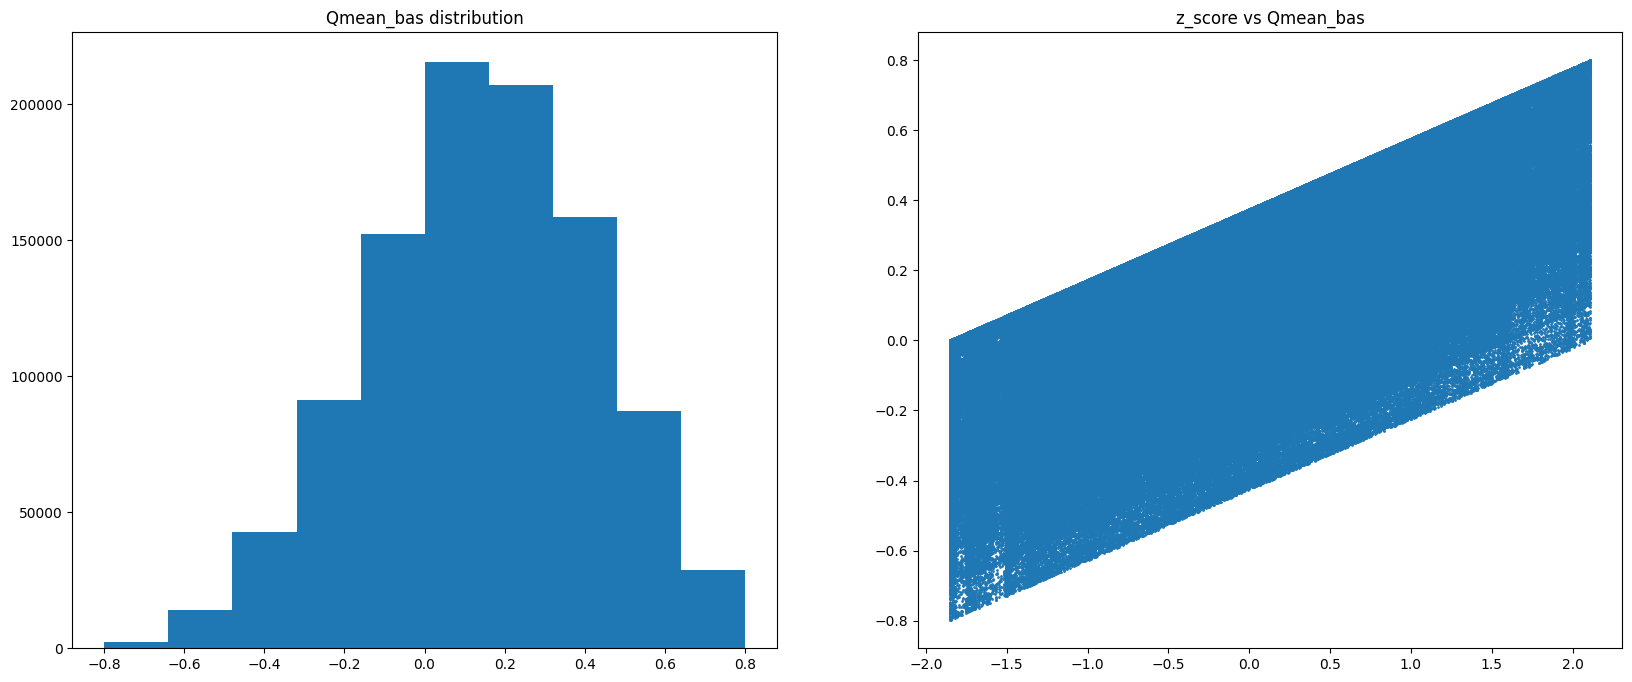

Pearson correlation z-score vs Qmean_bas (exceptional):0.021393579924155116


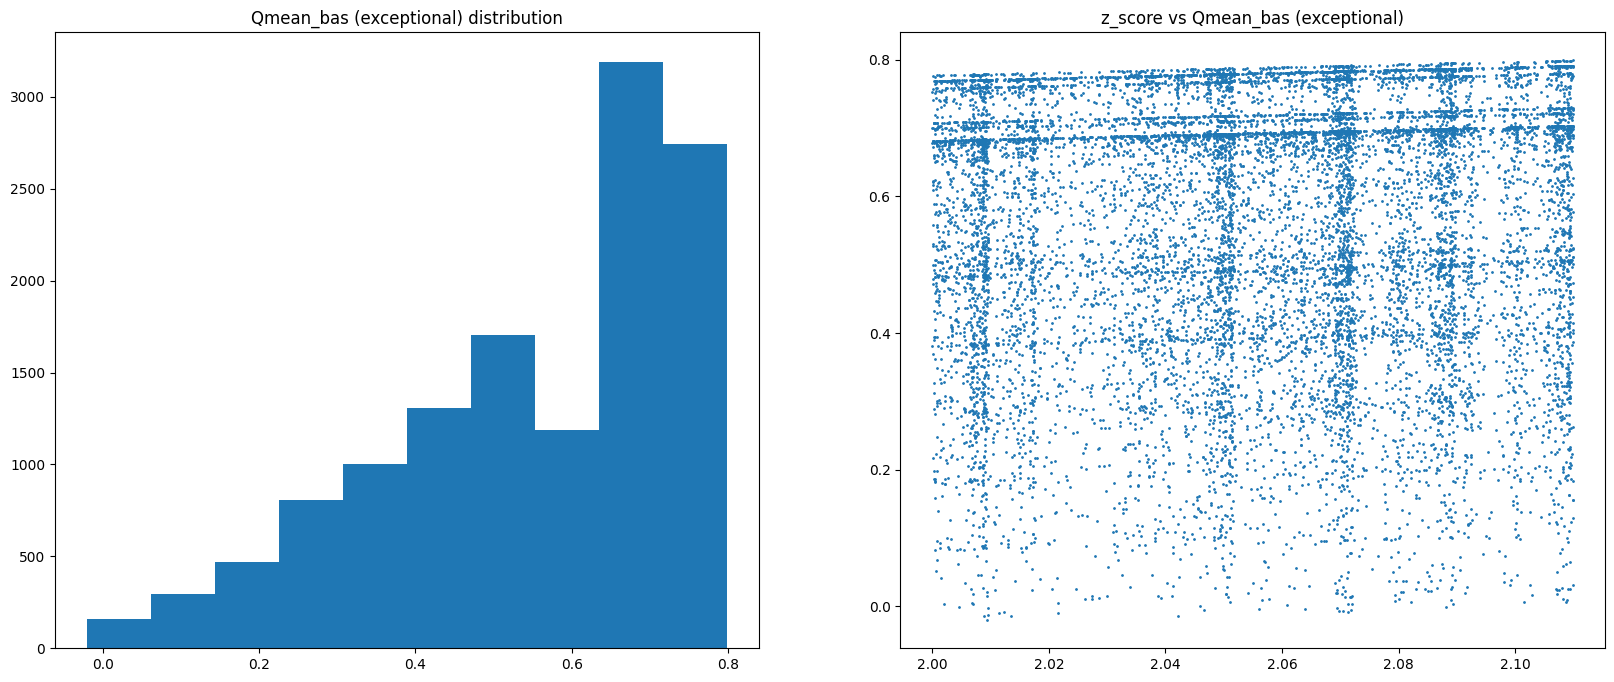

In [42]:
show_performance(z_scores, qmeans_bas, 'Qmean_bas')
show_performance(z_scores[exceptional_indices], qmeans_bas[exceptional_indices], 'Qmean_bas (exceptional)')

### Qmean_inv

Determines the exceptionality of a ranking by comparing it to the reversed ranking

Pearson correlation z-score vs Qmean_inv:0.9698817589127694


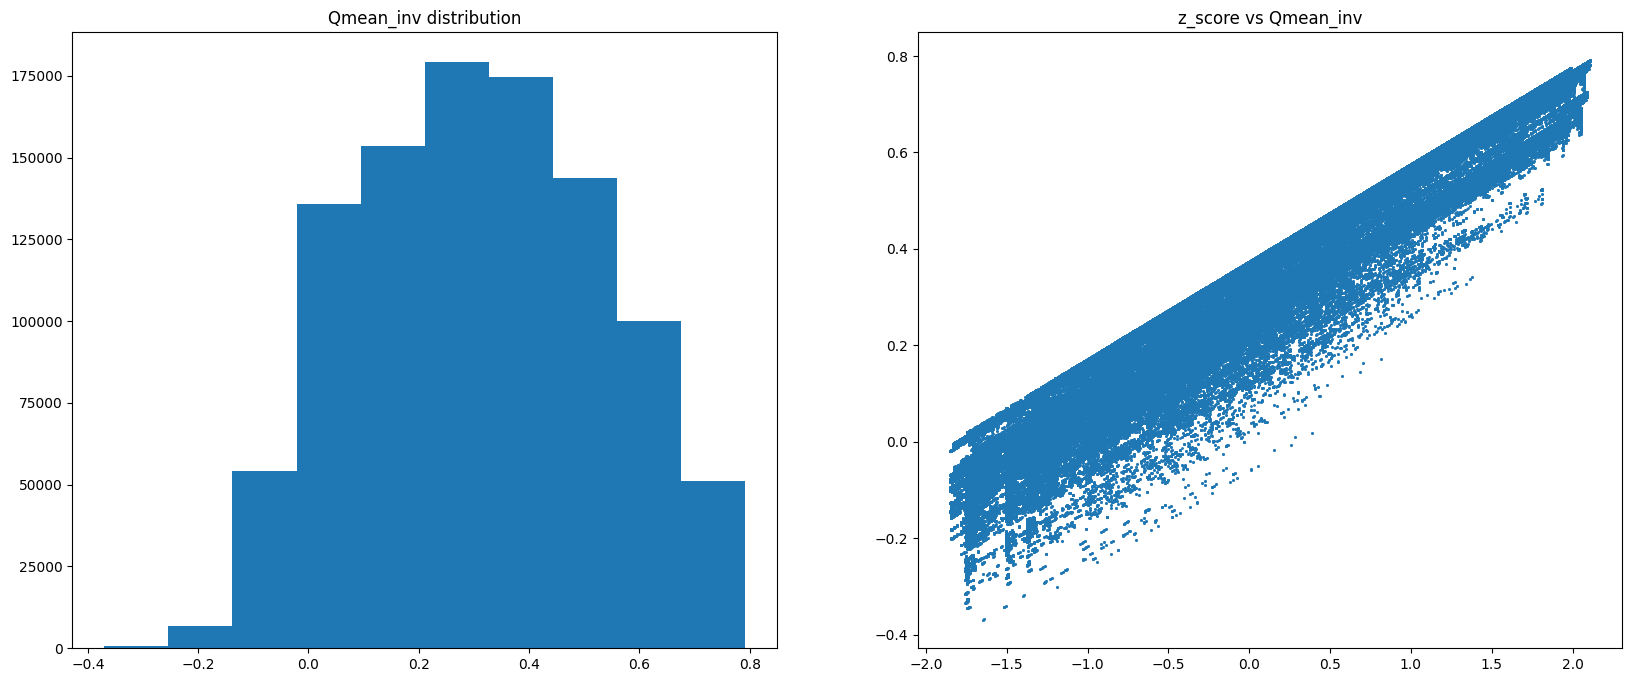

Pearson correlation z-score vs Qmean_inv (exceptional):0.2750981723593599


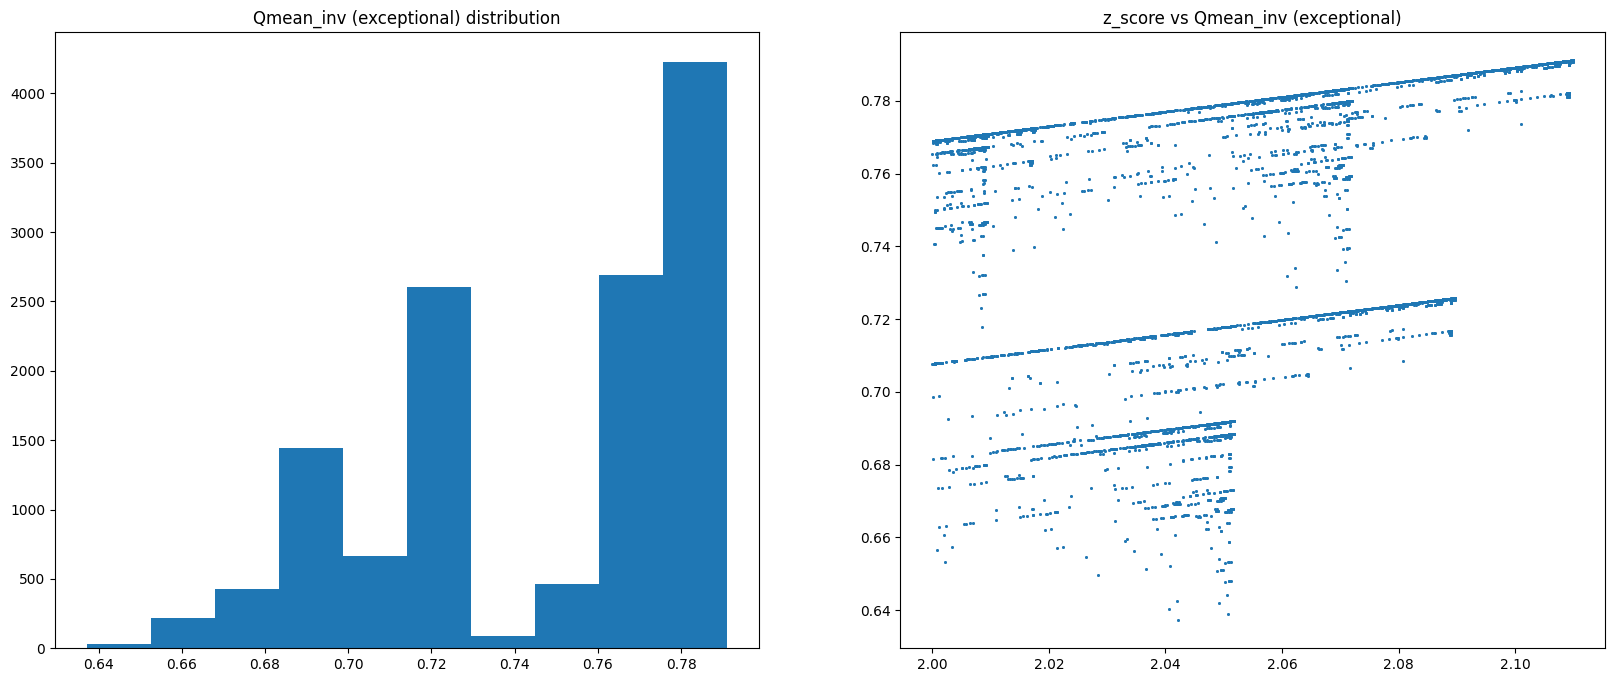

In [45]:
show_performance(z_scores, qmean_invs, 'Qmean_inv')
show_performance(z_scores[exceptional_indices], qmean_invs[exceptional_indices], 'Qmean_inv (exceptional)')

### Qmean_basX

Determines the exceptionality of a ranking by estimating mean and std with X random rankings

Pearson correlation z-score vs Qmean_bas2:0.8167415715407329


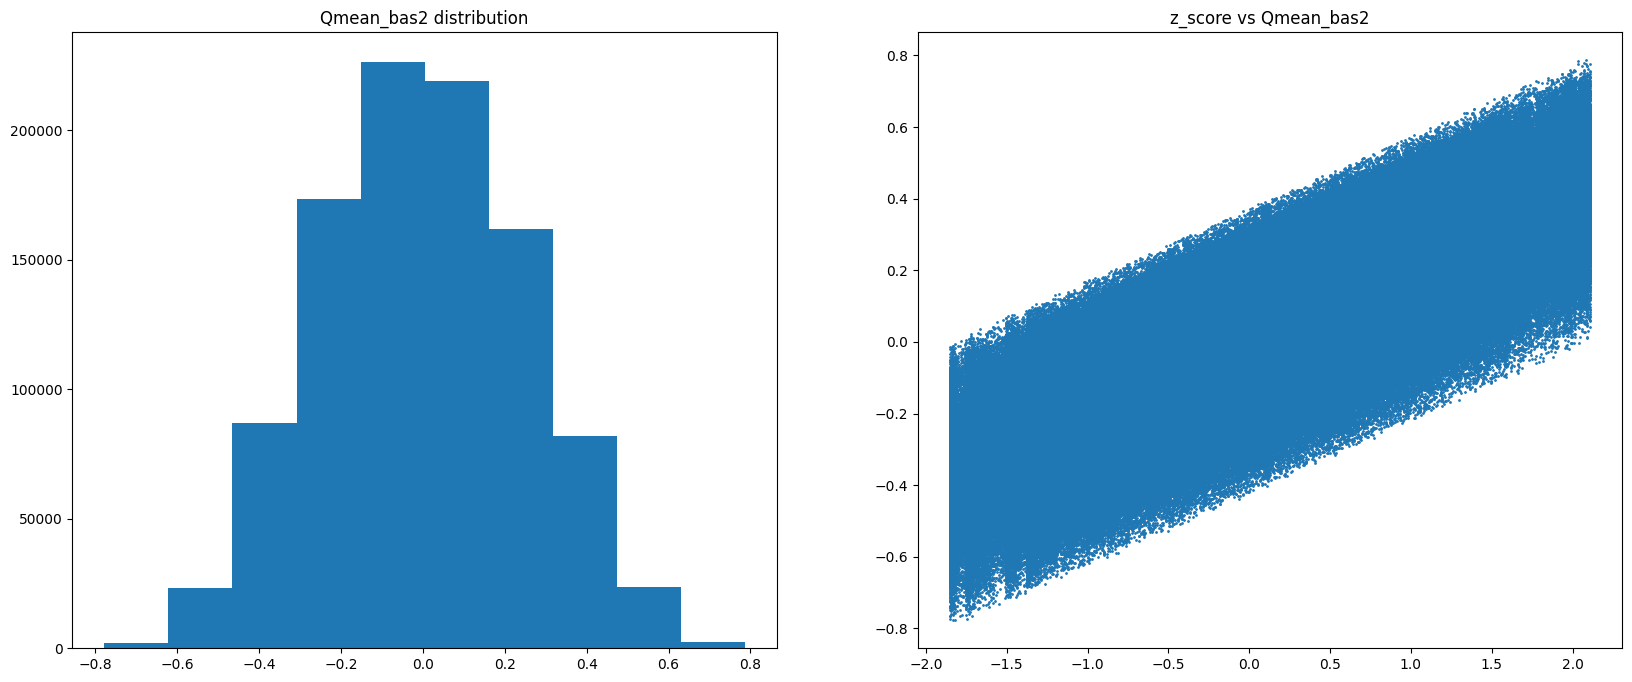

Pearson correlation z-score vs Qmean_bas2 (exceptional):0.042826694694321946


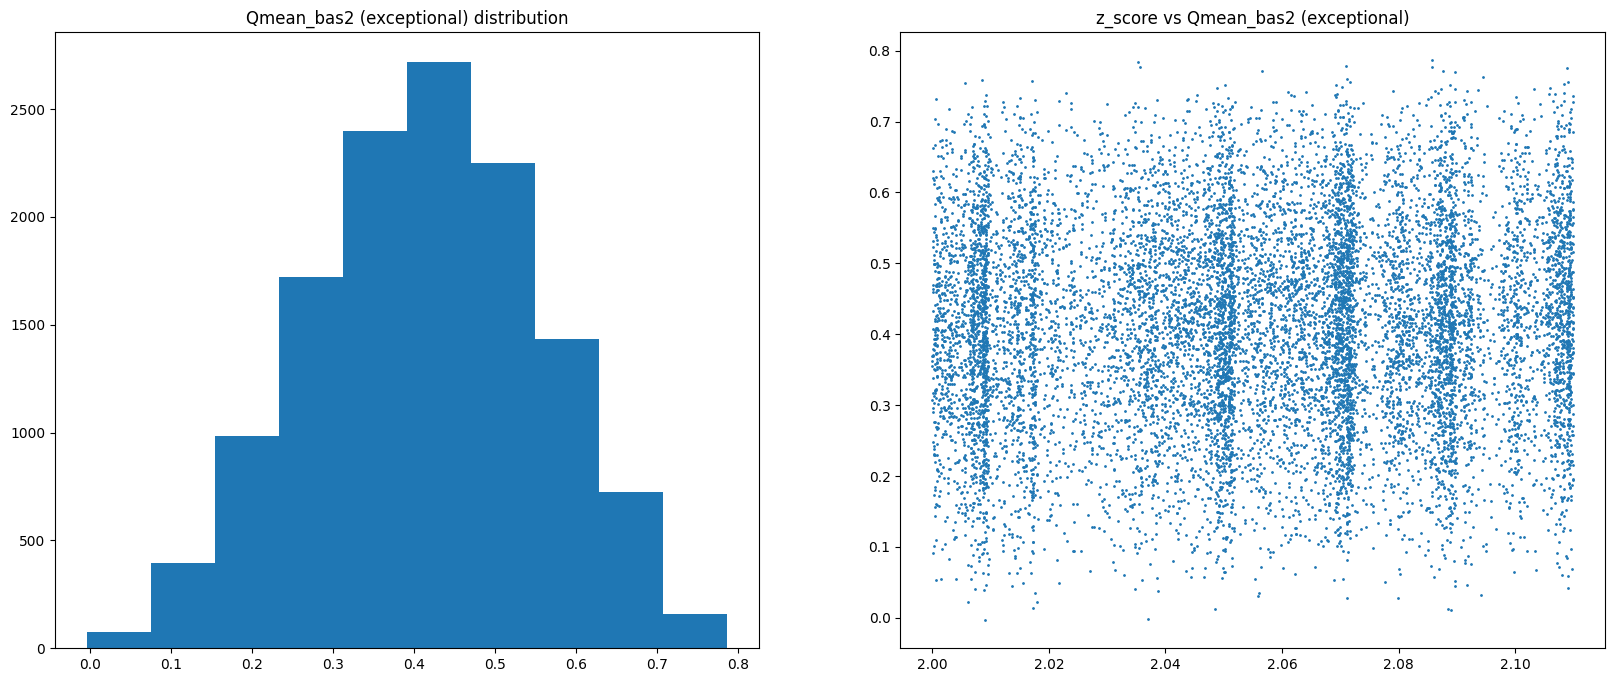

Pearson correlation z-score vs Qmean_bas3:0.8661373718347465


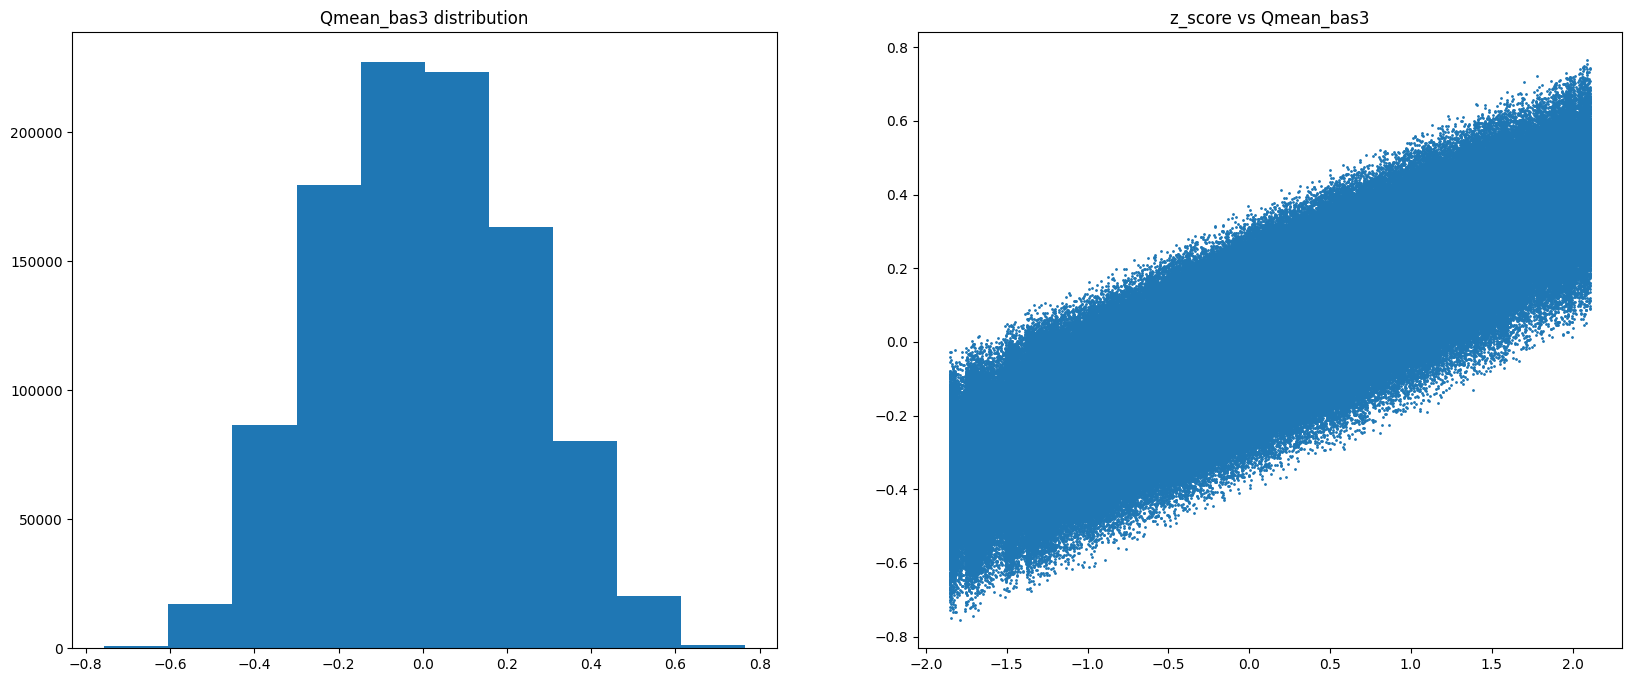

Pearson correlation z-score vs Qmean_bas3 (exceptional):0.04772953885775217


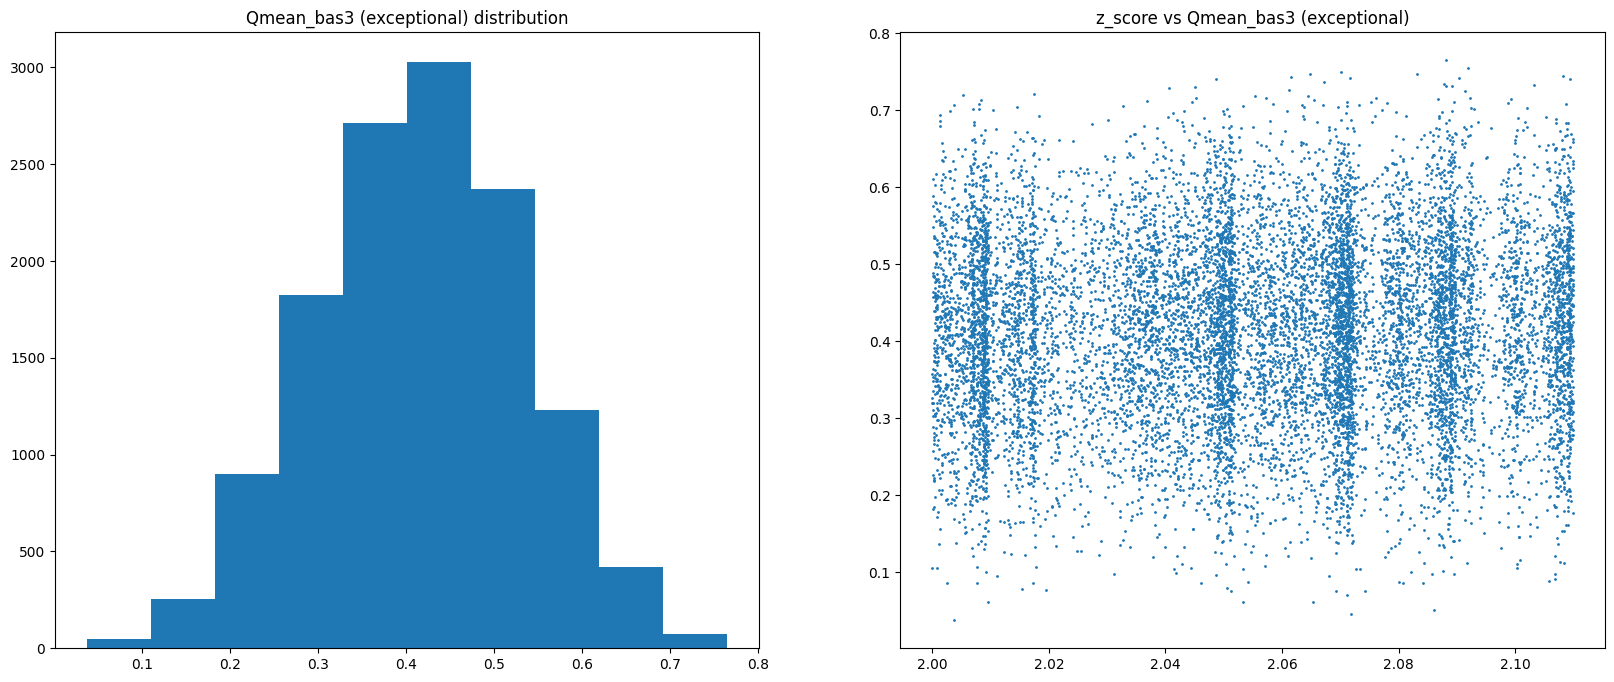

Pearson correlation z-score vs Qmean_bas4:0.8945387847325742


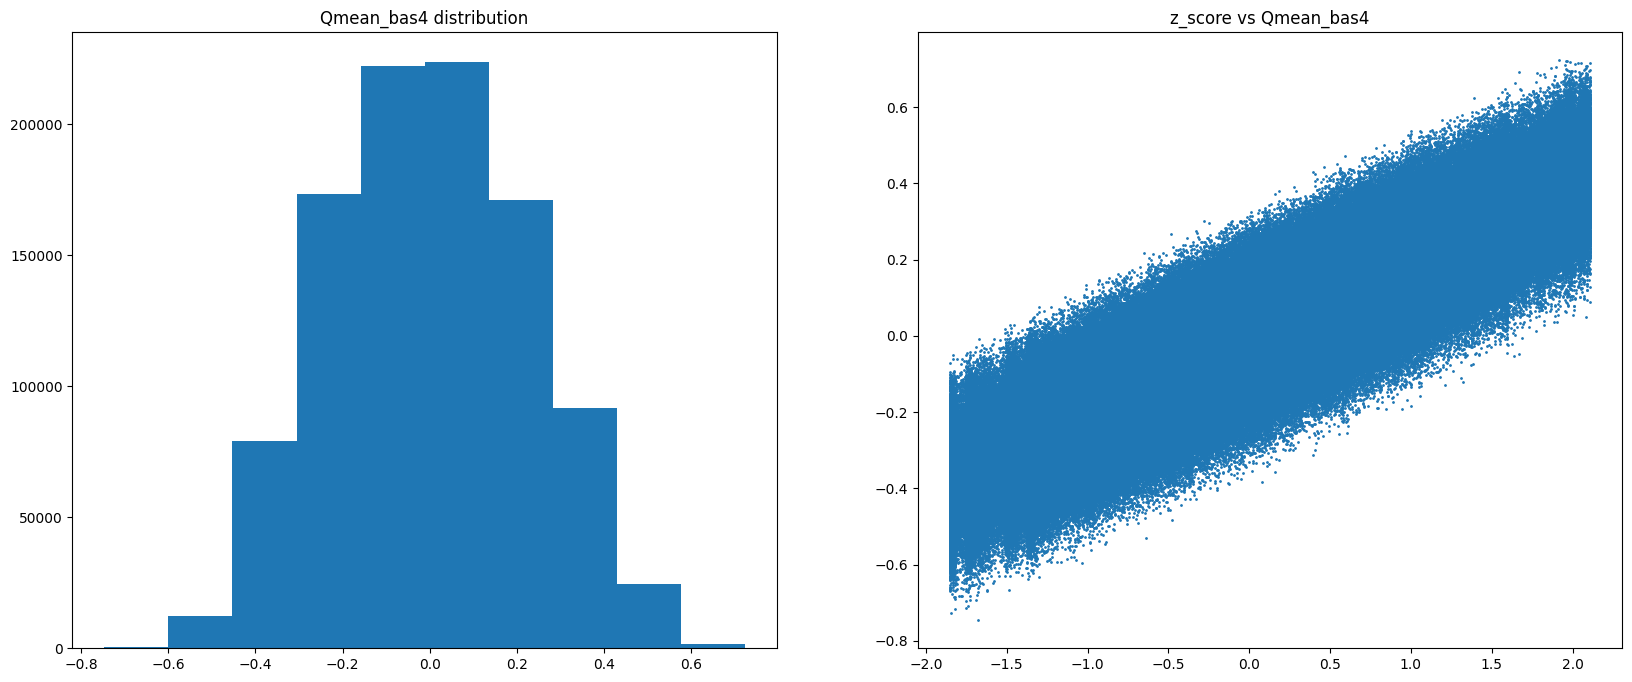

Pearson correlation z-score vs Qmean_bas4 (exceptional):0.05833520517185447


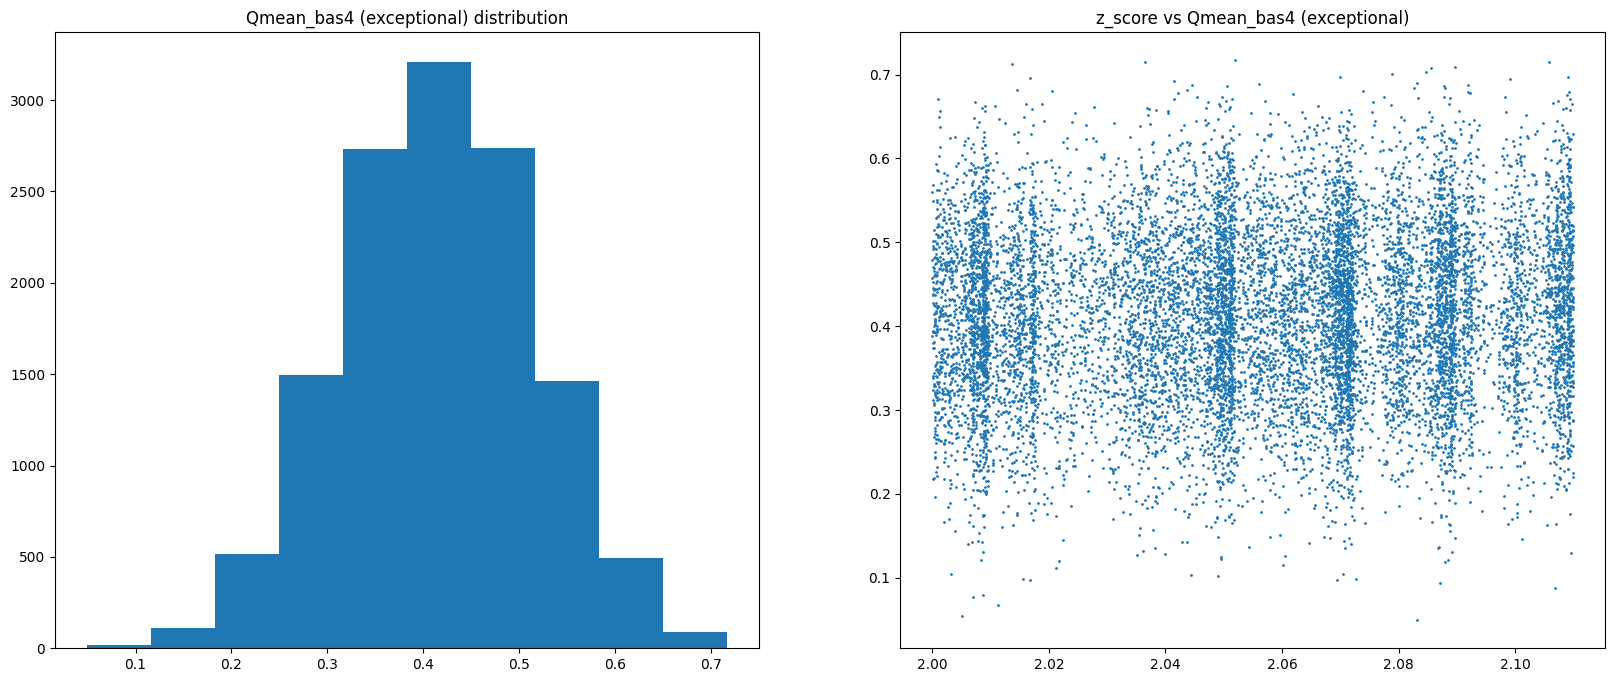

Pearson correlation z-score vs Qmean_bas5:0.9128027194824719


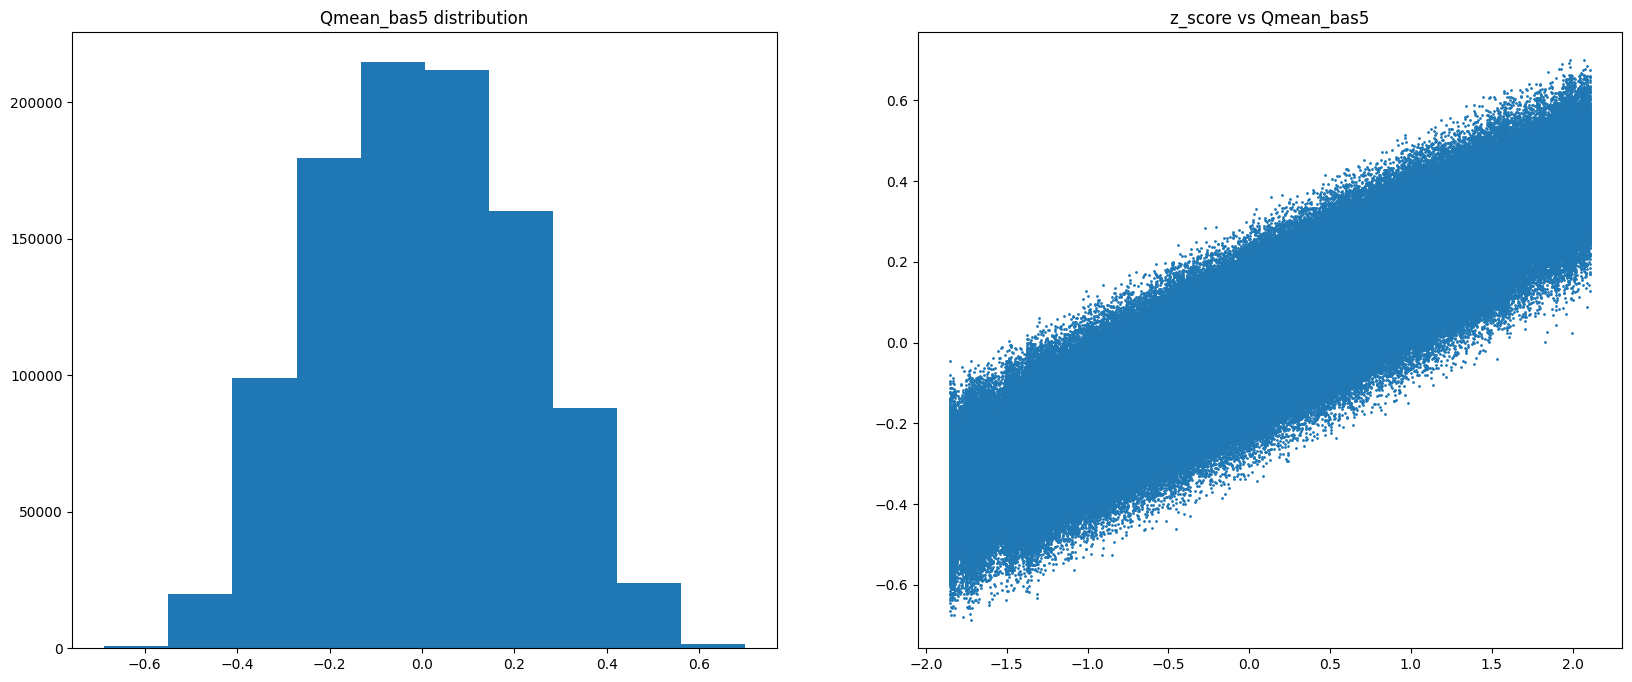

Pearson correlation z-score vs Qmean_bas5 (exceptional):0.08362148086001911


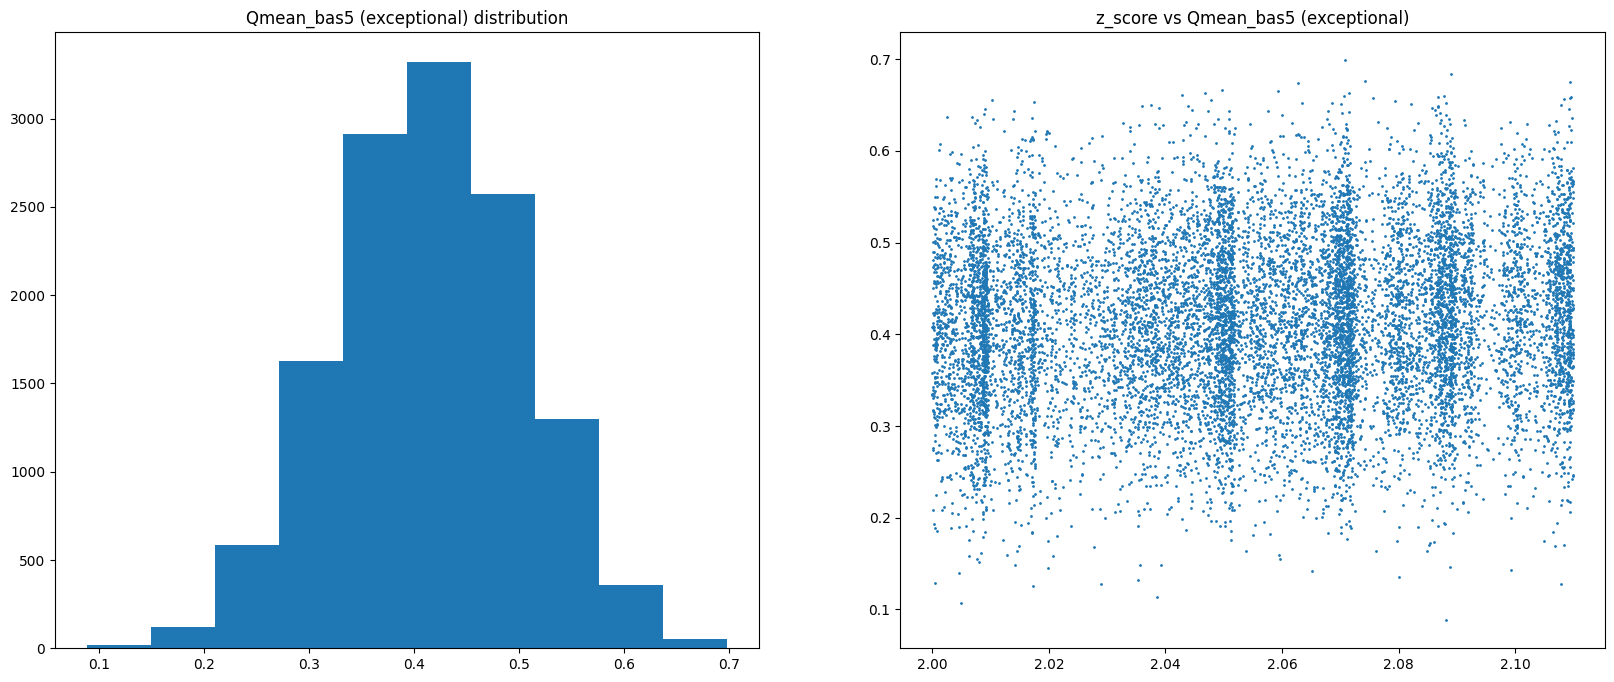

Pearson correlation z-score vs Qmean_bas6:0.9259440019965247


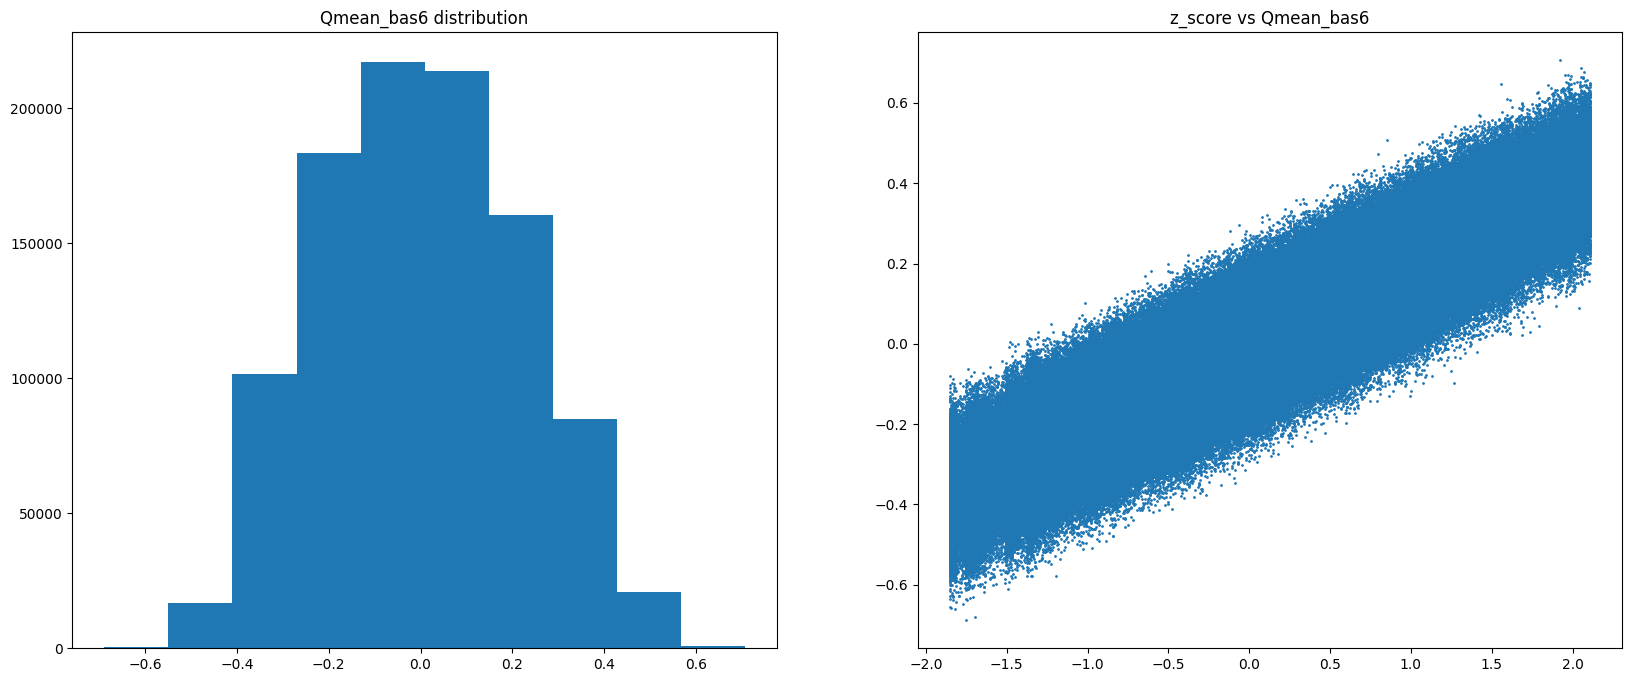

Pearson correlation z-score vs Qmean_bas6 (exceptional):0.0772497789958999


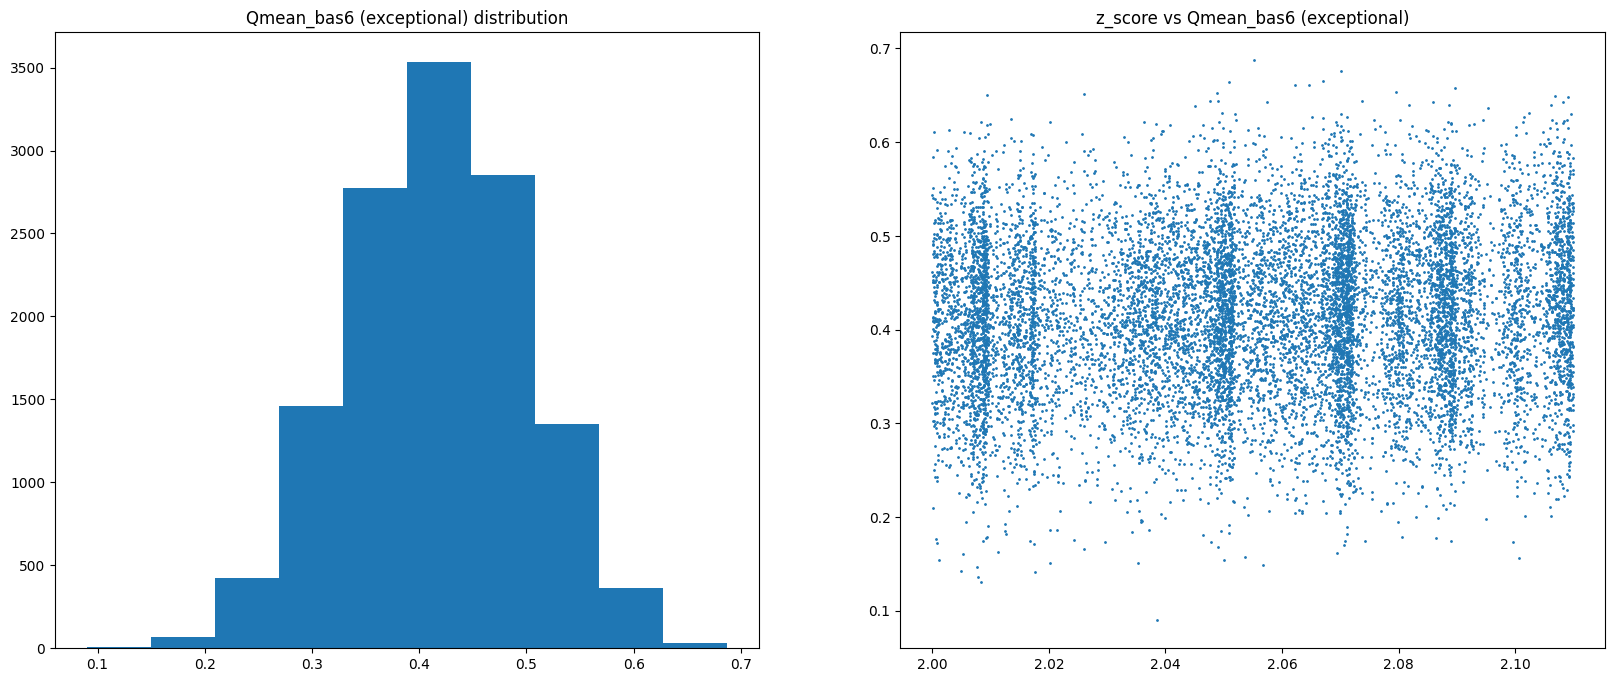

Pearson correlation z-score vs Qmean_bas7:0.9353919256182515


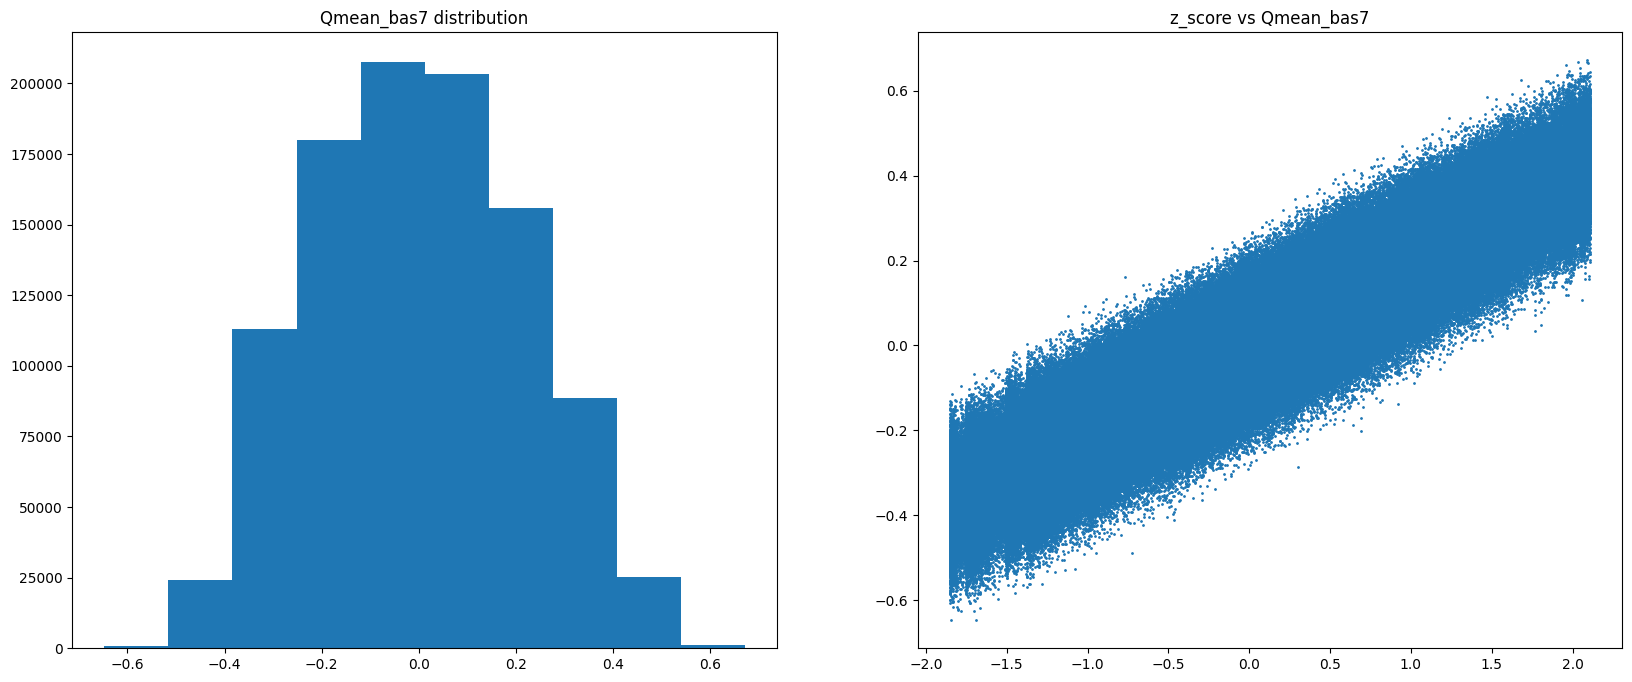

Pearson correlation z-score vs Qmean_bas7 (exceptional):0.08451233384246624


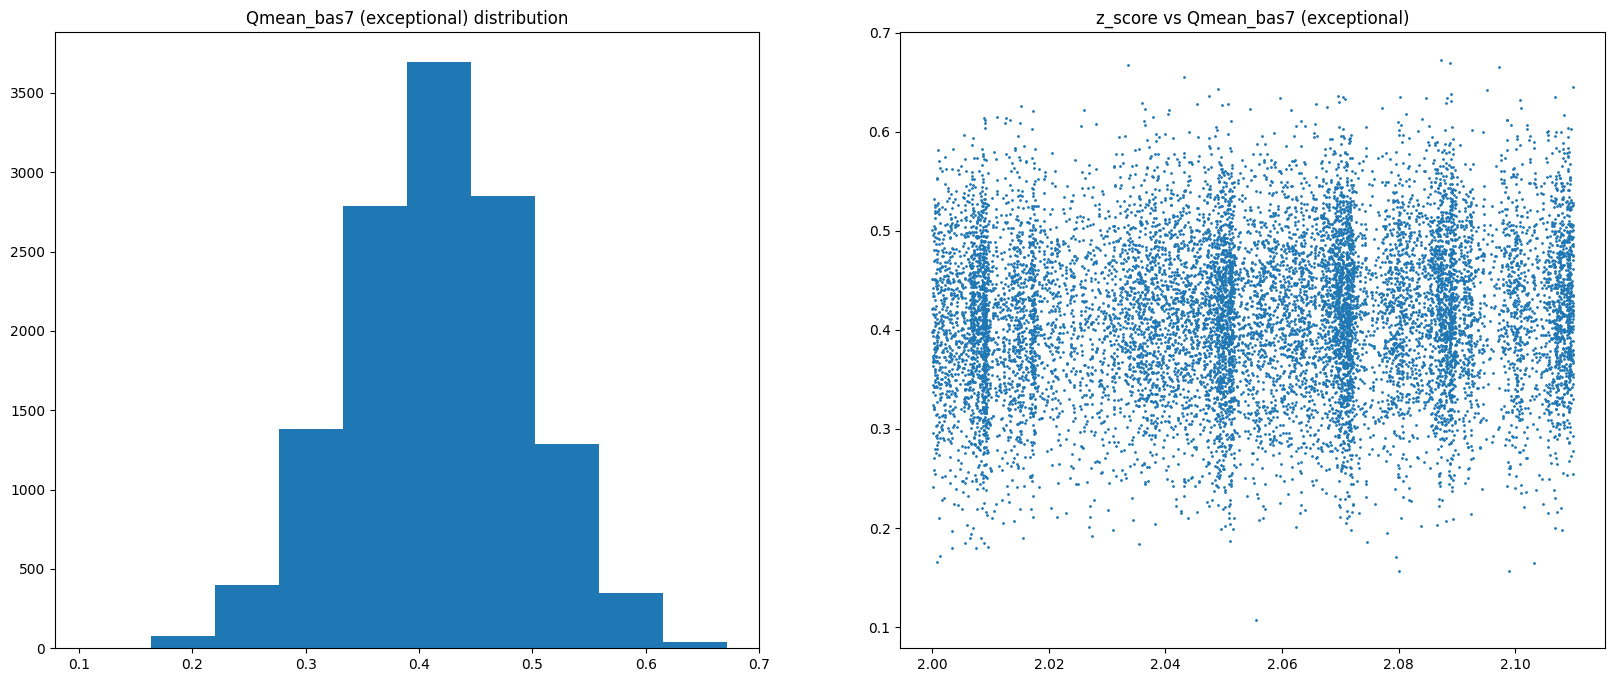

Pearson correlation z-score vs Qmean_bas8:0.9428463989523407


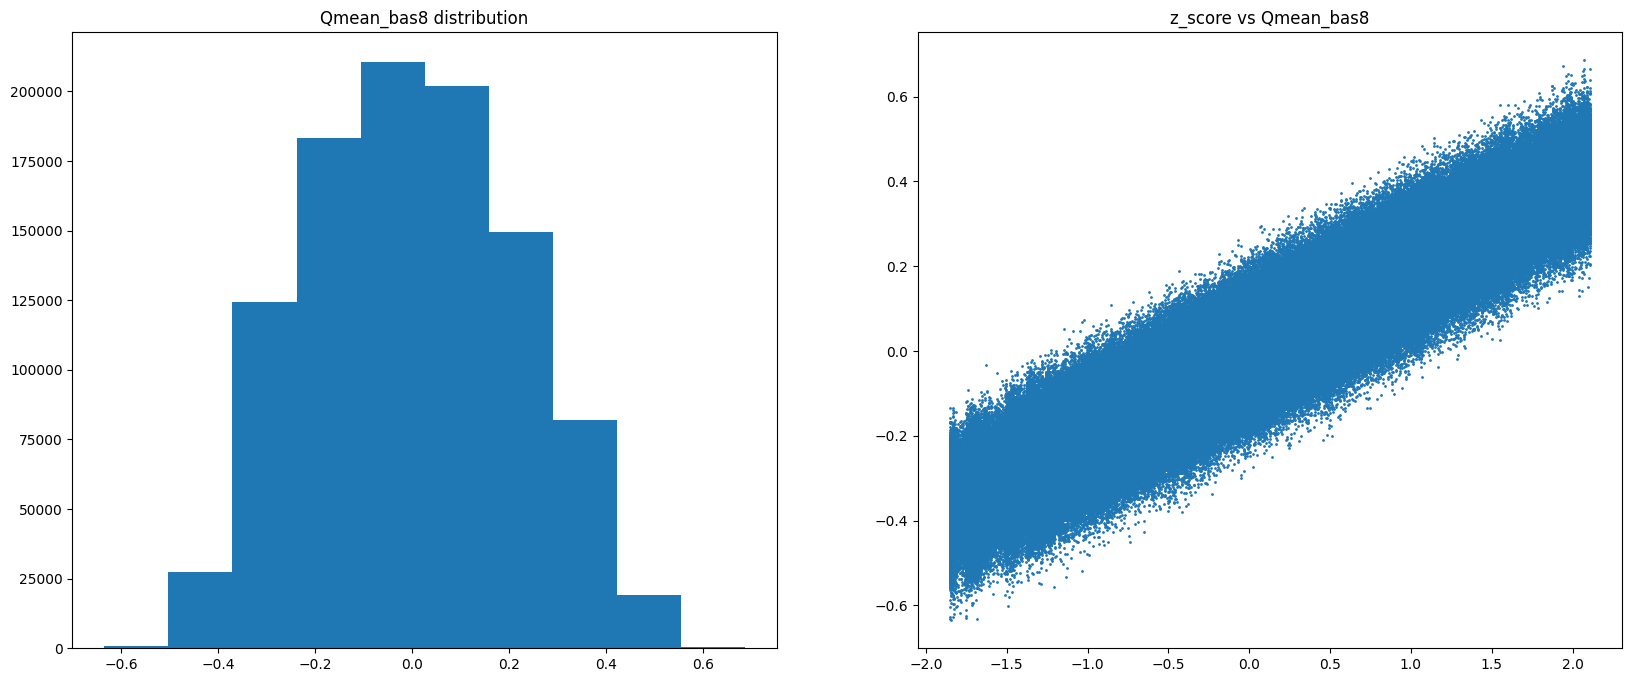

Pearson correlation z-score vs Qmean_bas8 (exceptional):0.08508812586298375


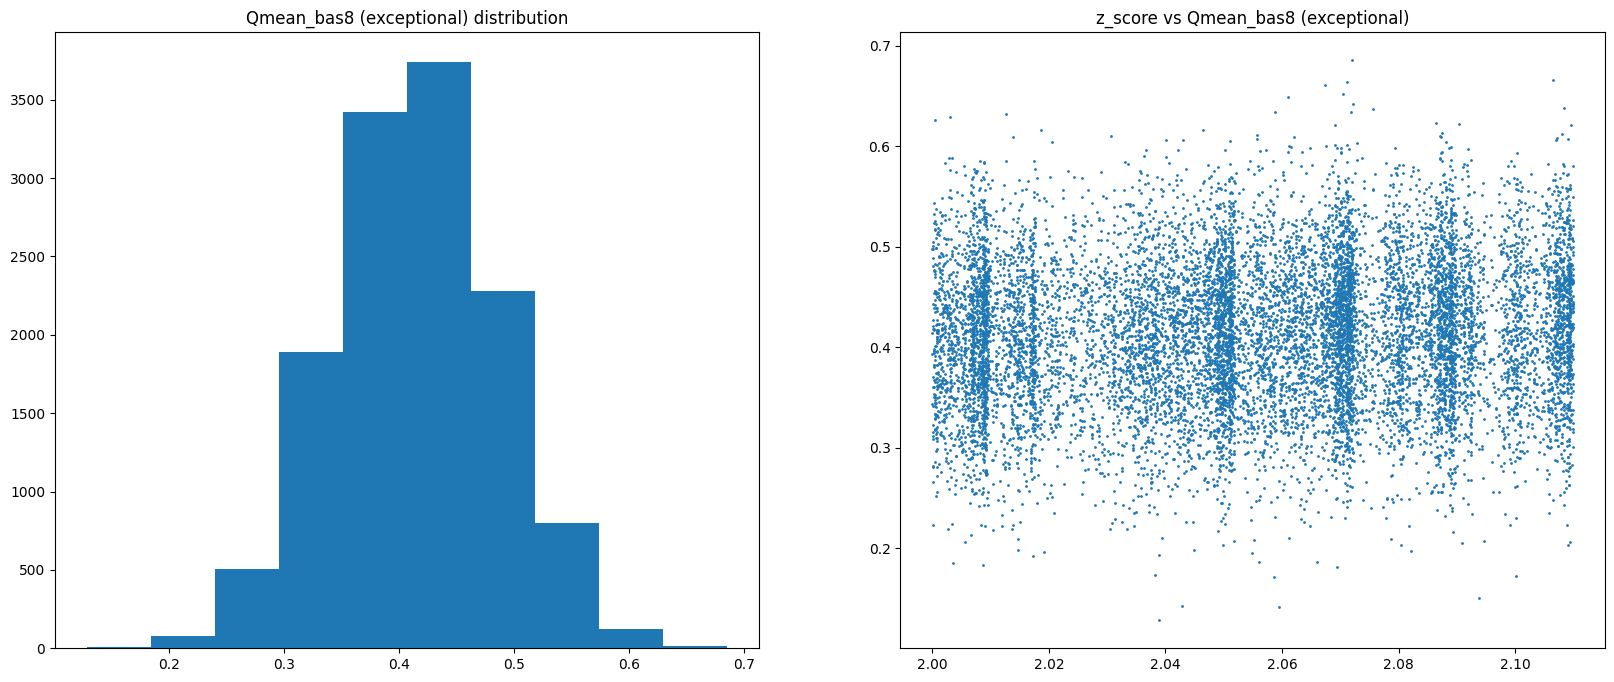

Pearson correlation z-score vs Qmean_bas9:0.9487405796242127


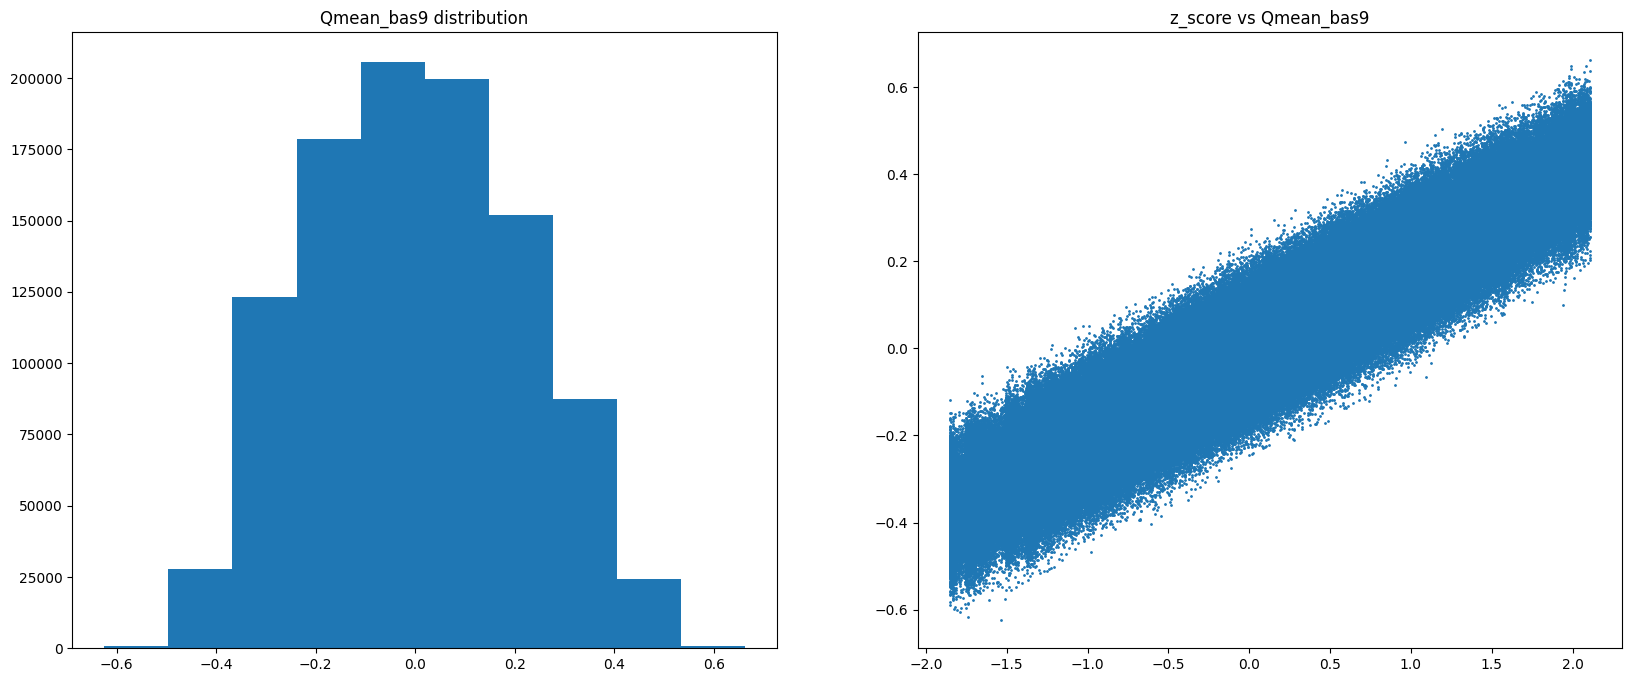

Pearson correlation z-score vs Qmean_bas9 (exceptional):0.10178087342594695


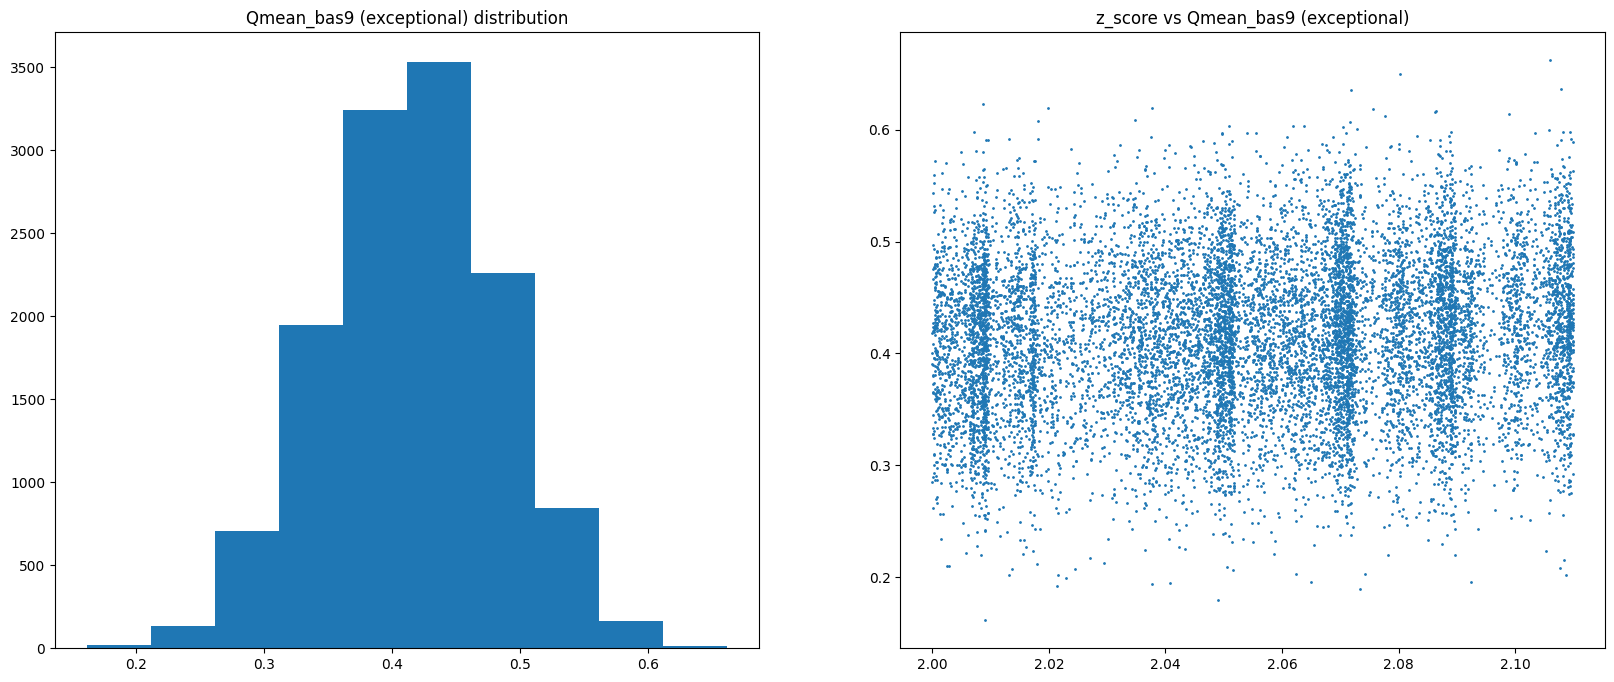

Pearson correlation z-score vs Qmean_bas10:0.9535156151428366


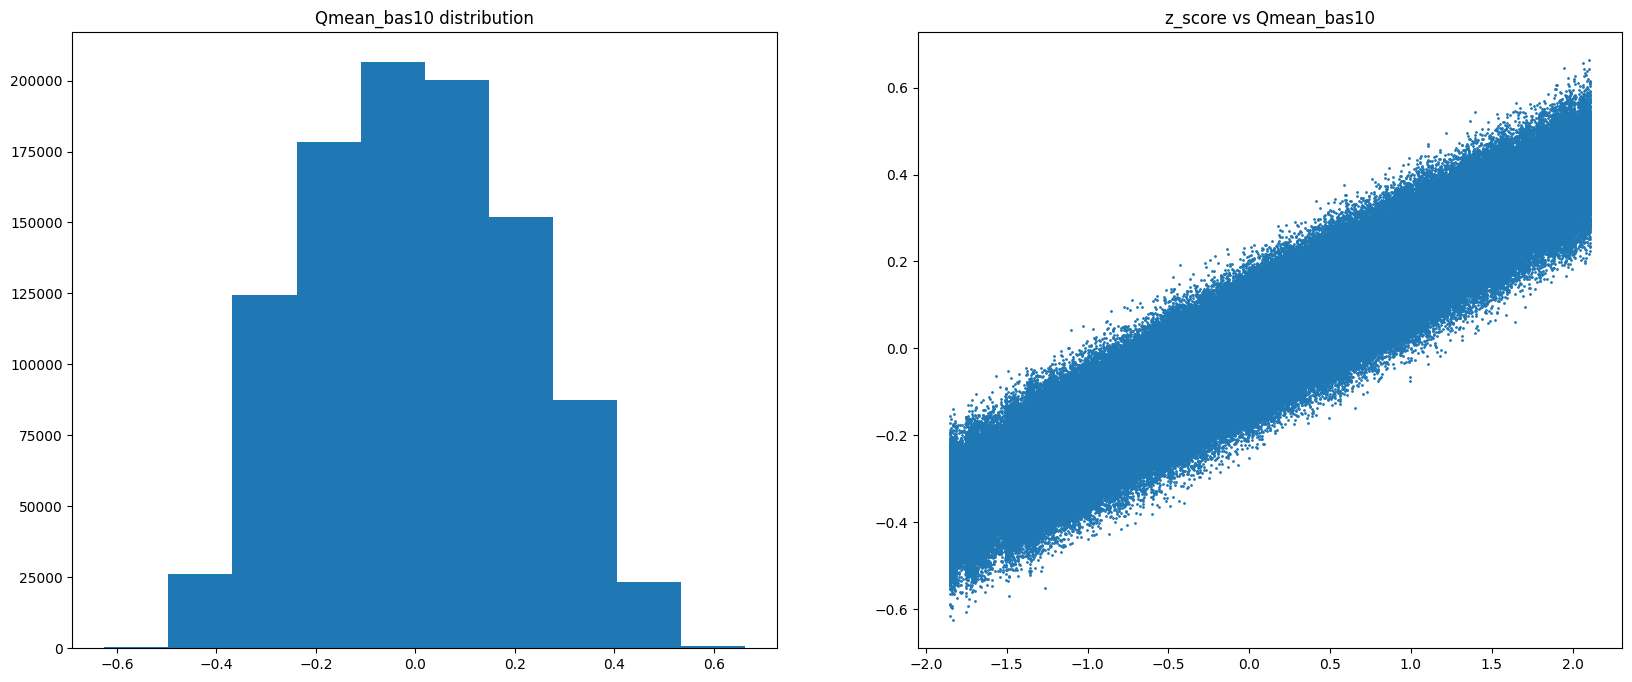

Pearson correlation z-score vs Qmean_bas10 (exceptional):0.10838699820430393


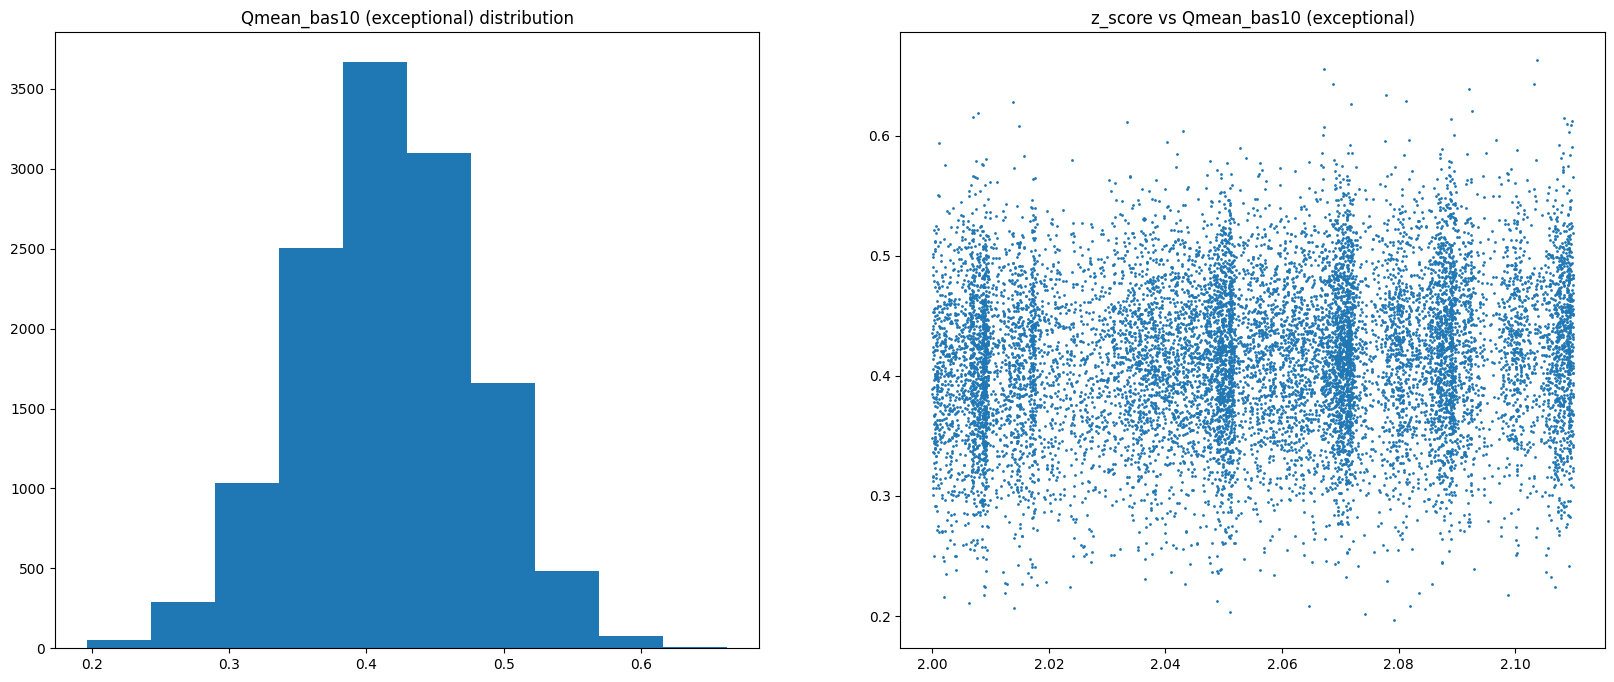

In [51]:
def compute_qbas(measure, num_samples):
    random_indices = np.random.randint(0,  measure.shape[0], (measure.shape[0], num_samples))
    random_qmeans = measure[random_indices]
    mean = np.mean(random_qmeans, axis=1)

    # First way to deal with std==0; add some epsilon
    #std = np.std(random_qmeans, axis=1) + 1e-10

    # Second way to deal with std==0; ignore std (divide by 1)
    std = np.std(random_qmeans, axis=1)
    std[std==0] = 1

    # Always ignore std
    std=1
    return (measure - mean) / std

## Computing Qmean_basX
for i in range(2,11):
    # Take two random indices for each sample
    qmean_basX = compute_qbas(qmeans.flatten(), i)
    show_performance(z_scores, qmean_basX, f'Qmean_bas{i}')
    show_performance(z_scores[exceptional_indices], qmean_basX[exceptional_indices], f'Qmean_bas{i} (exceptional)')

# Explore metrics included in Quantus

Data includes:
 - Faithfulness correlation
 - Monotonicity correlation
 - Pixel flipping

In [58]:
faithfulness_correlations = data['faithfulness_correlations'][:1000001] # Truncate only for 1M file
monotonicity_correlations = data['monotonicity_correlations'][:1000001]
pixel_flippings = data['pixel_flippings'][:1000001]
# For pixel flippings, take average activation
pixel_flipping_activations = np.mean(pixel_flippings, axis=1)

Pearson correlation z-score vs Faithfulness correlations:-0.4705079498613055


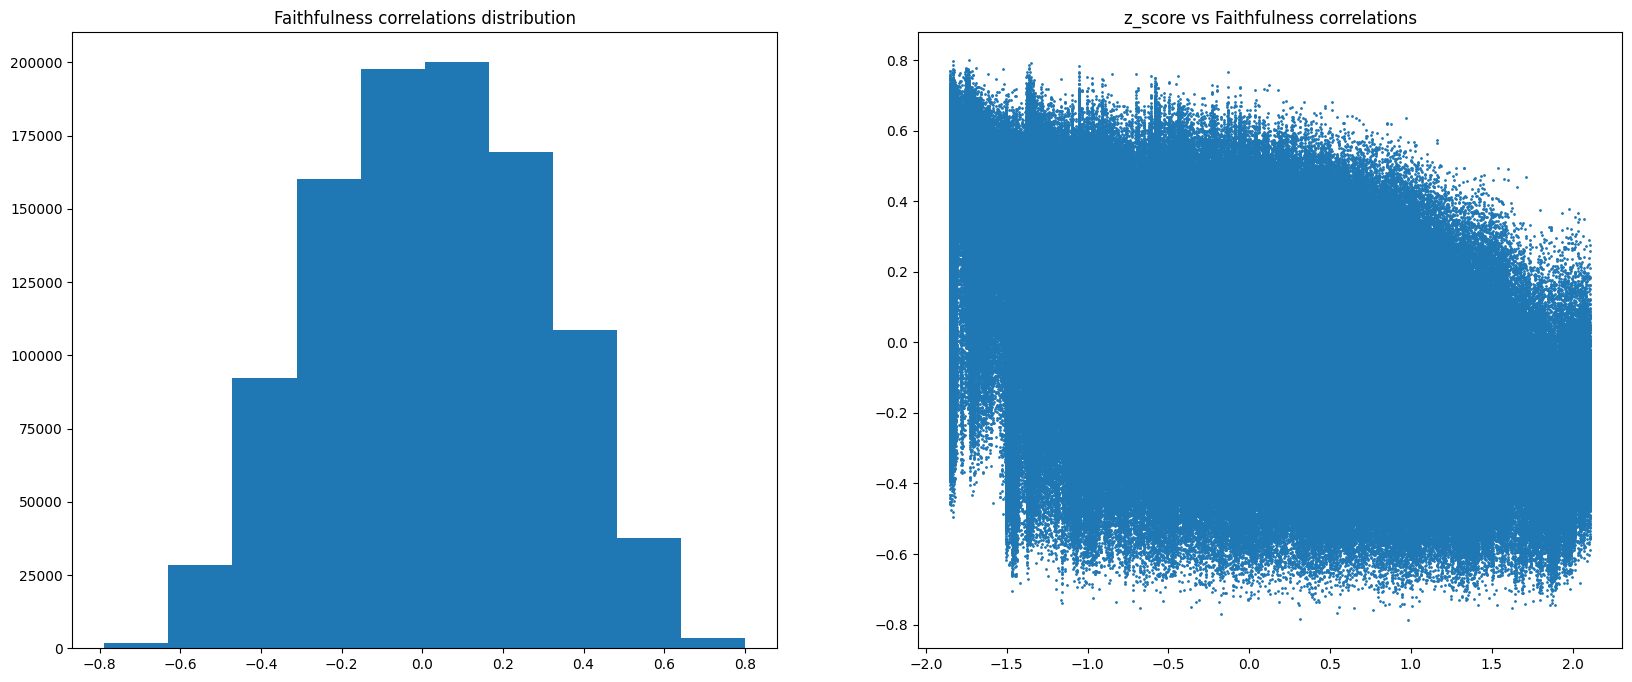

Pearson correlation z-score vs Faithfulness correlations (exceptional):0.07382195935446895


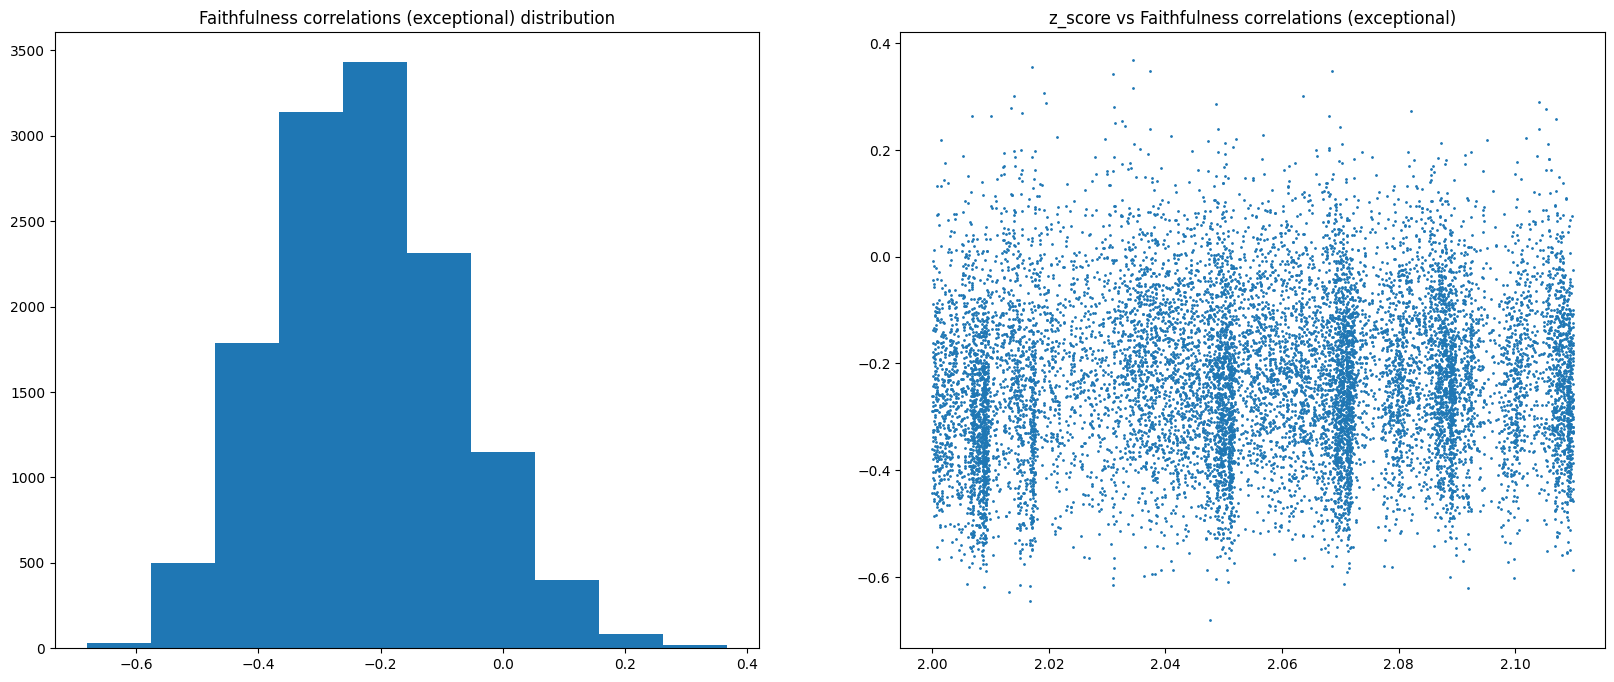

Pearson correlation z-score vs Monotonicity correlations:-0.48314280862905484


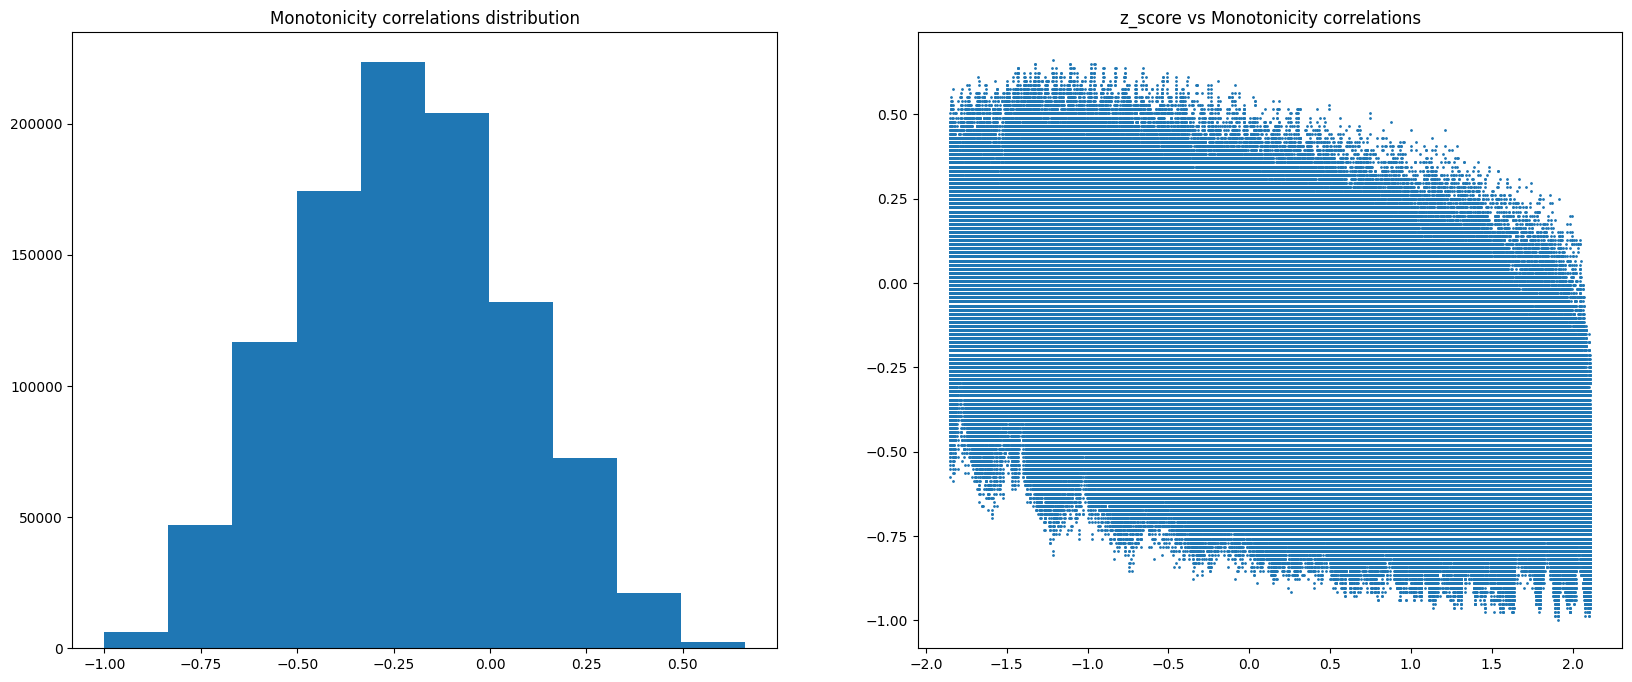

Pearson correlation z-score vs Monotonicity correlations (exceptional):-0.2929562383274803


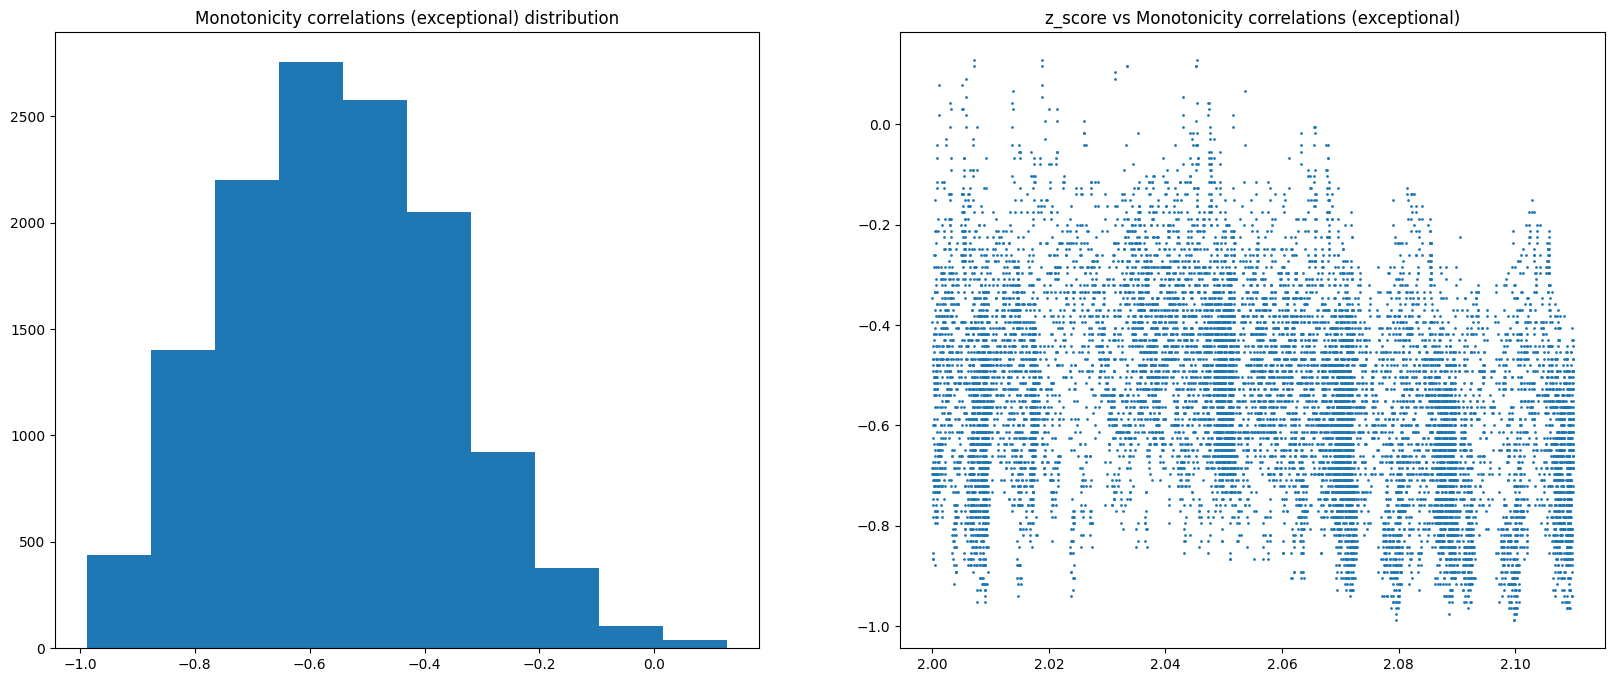

Pearson correlation z-score vs Pixel flipping activations:0.4564813774566202


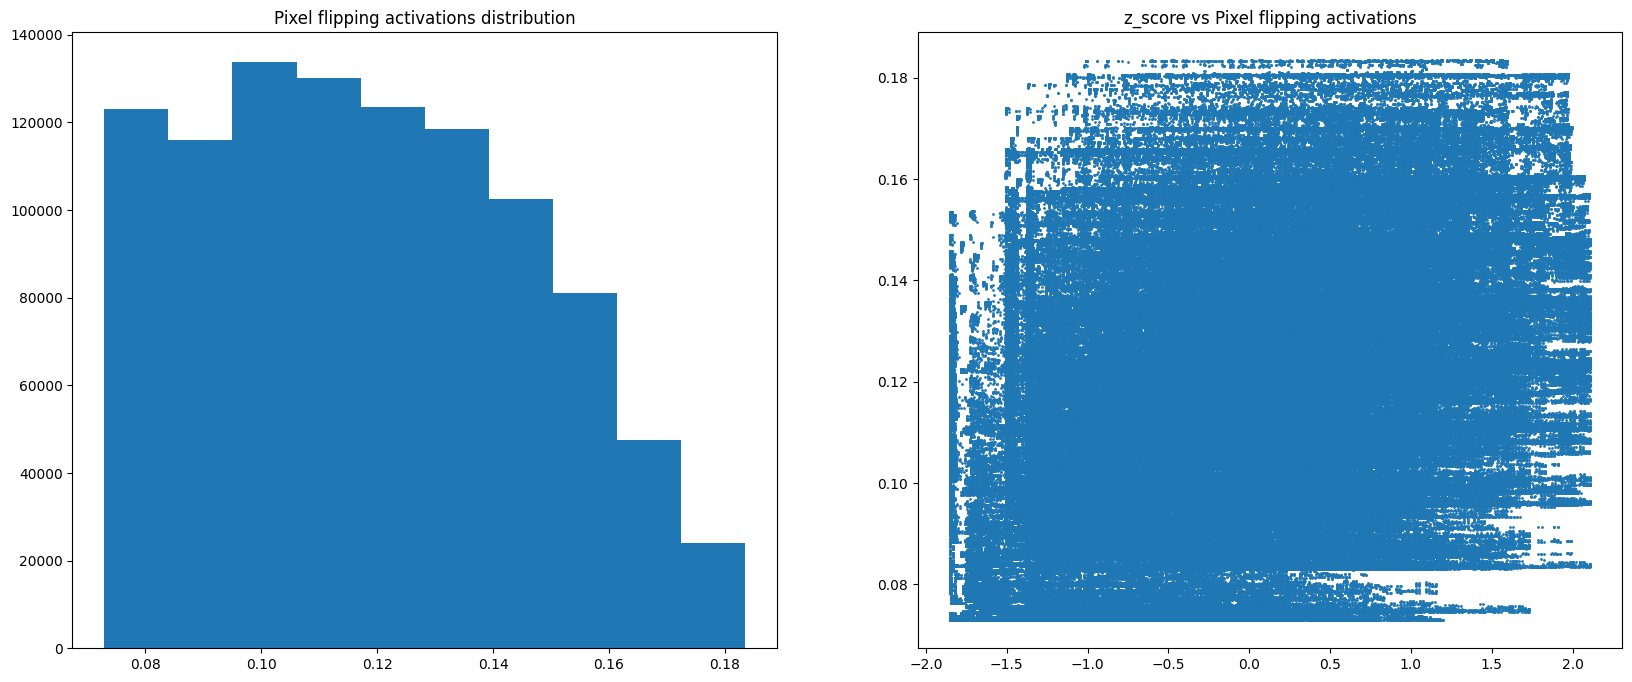

Pearson correlation z-score vs Pixel flipping activations (exceptional):0.06682008299248293


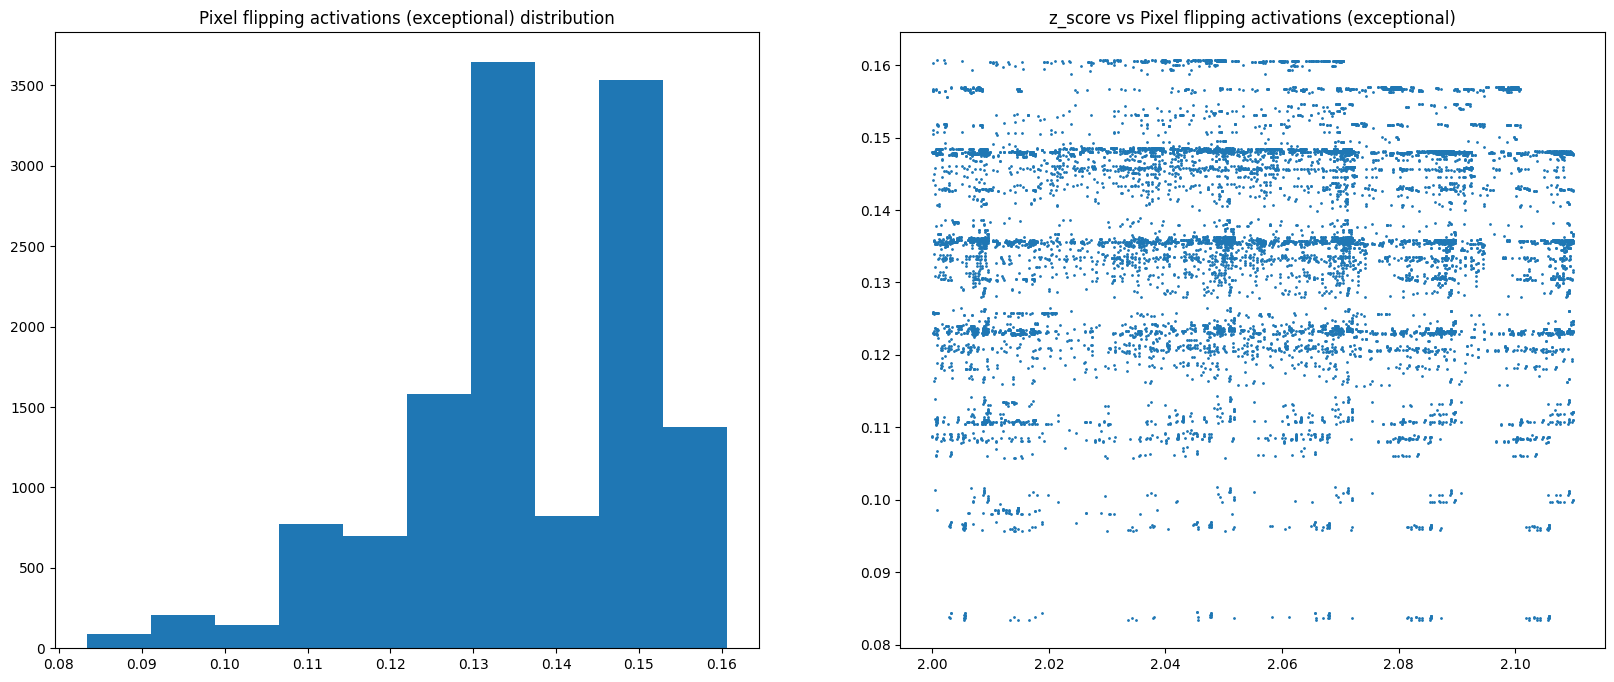

In [61]:
show_performance(z_scores, faithfulness_correlations, f'Faithfulness correlations')
show_performance(z_scores[exceptional_indices], faithfulness_correlations[exceptional_indices], f'Faithfulness correlations (exceptional)')
show_performance(z_scores, monotonicity_correlations, f'Monotonicity correlations')
# The following one gives a remarkable result
show_performance(z_scores[exceptional_indices], monotonicity_correlations[exceptional_indices], f'Monotonicity correlations (exceptional)')
show_performance(z_scores, pixel_flipping_activations, f'Pixel flipping activations')
show_performance(z_scores[exceptional_indices], pixel_flipping_activations[exceptional_indices], f'Pixel flipping activations (exceptional)')


## Explore Qinv across the different levels of exceptionality

502825 elements with z_score in [-inf,0)
Pearson correlation z-score vs Qmean_inv (z_score in [-inf,0)):0.8828117963803869


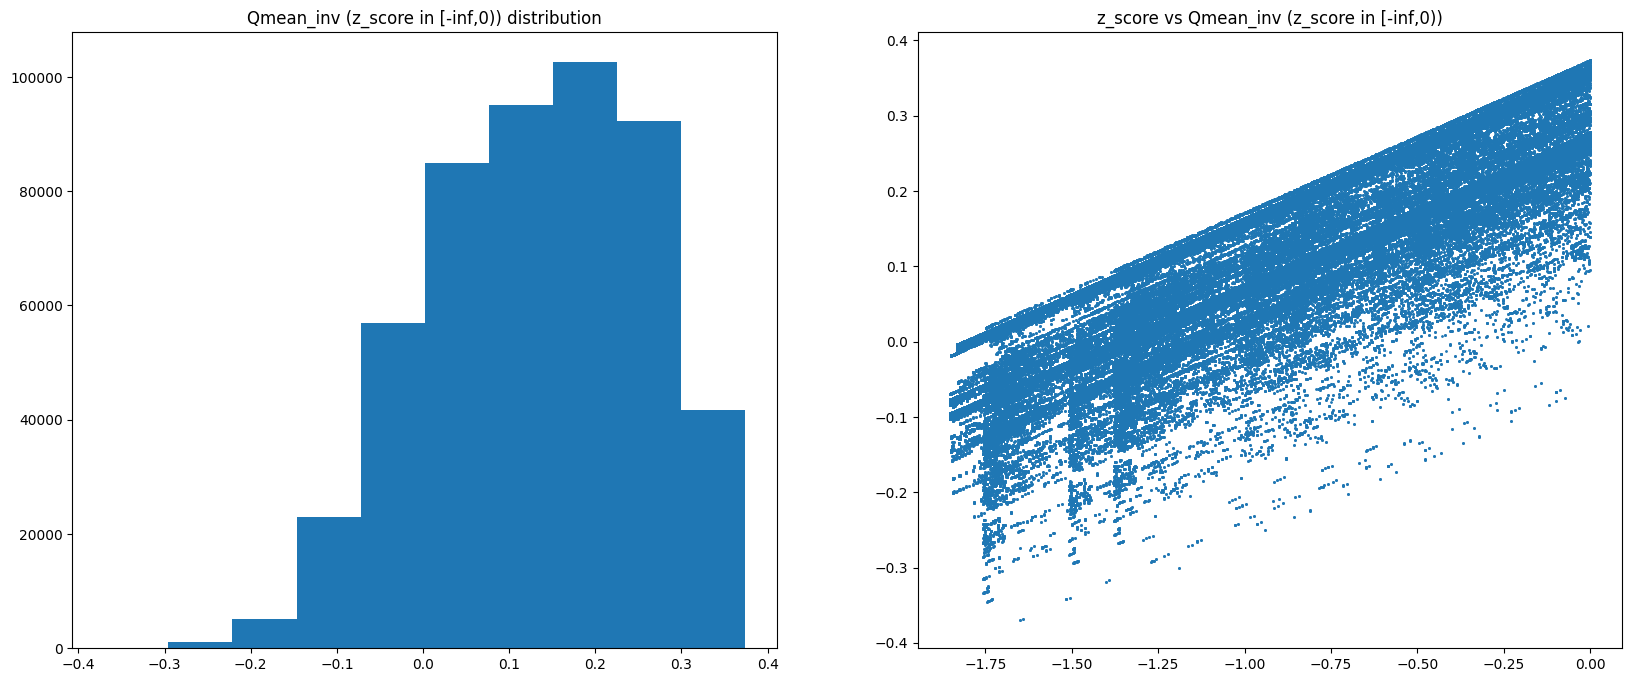

167211 elements with z_score in [0,0.5)
Pearson correlation z-score vs Qmean_inv (z_score in [0,0.5)):0.5199376636920974


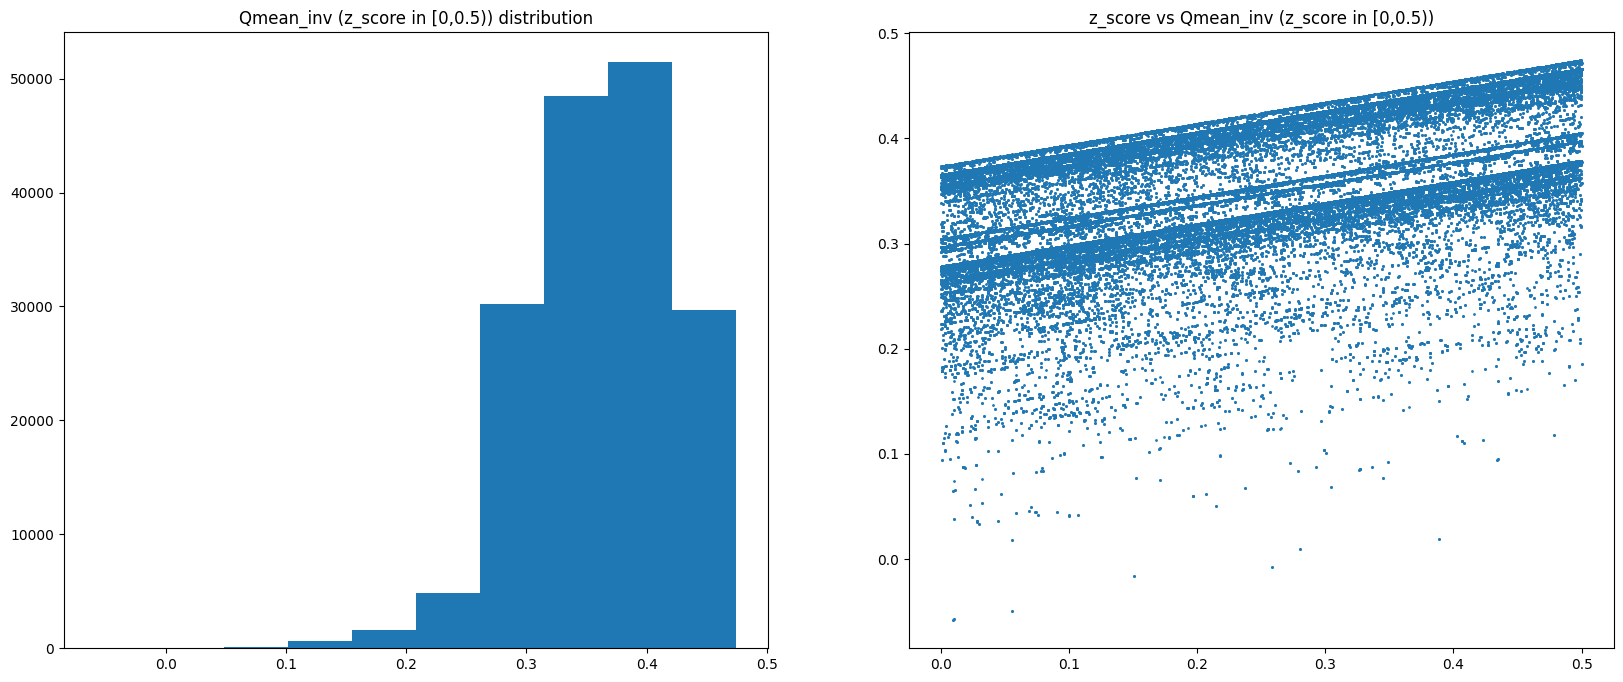

144984 elements with z_score in [0.5,1)
Pearson correlation z-score vs Qmean_inv (z_score in [0.5,1)):0.5366696005626356


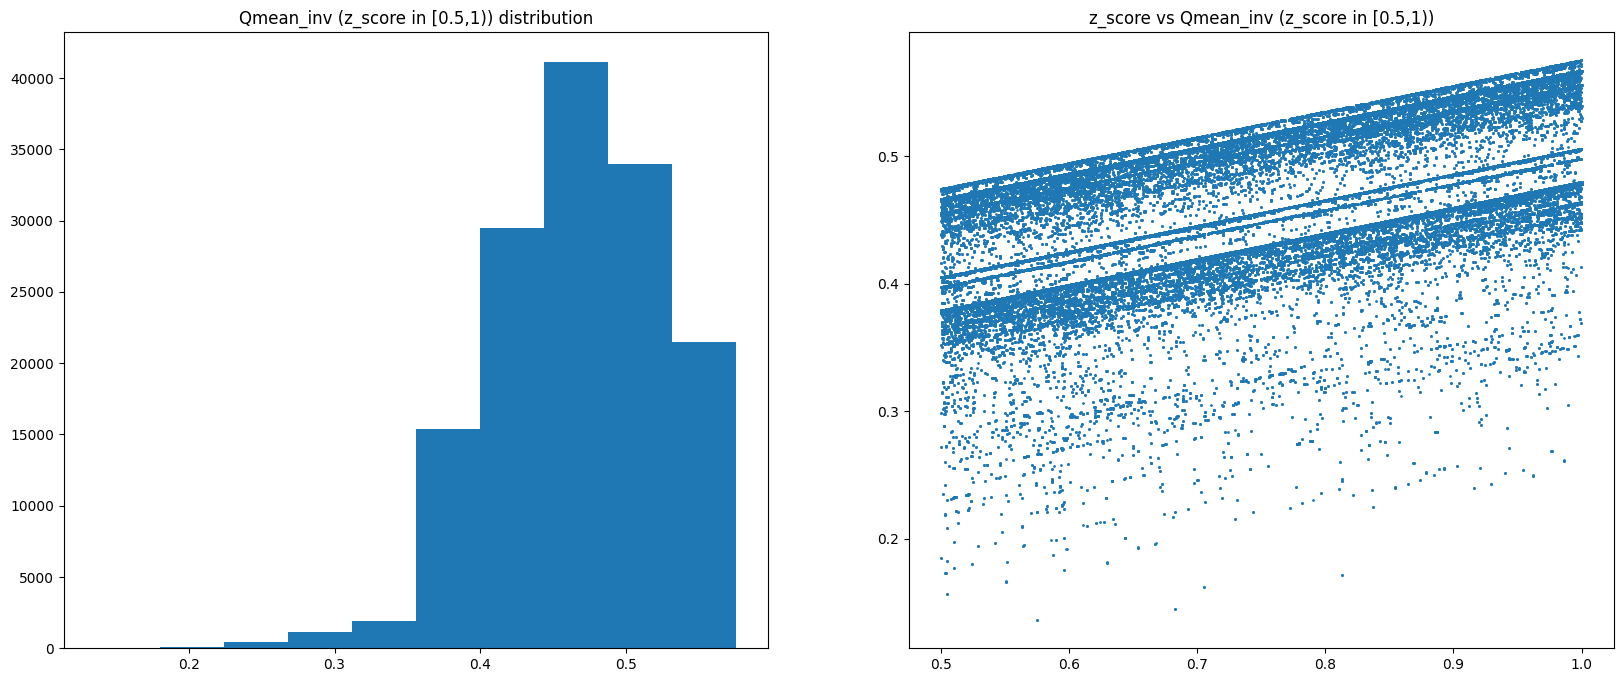

102820 elements with z_score in [1,1.5)
Pearson correlation z-score vs Qmean_inv (z_score in [1,1.5)):0.5424205796804571


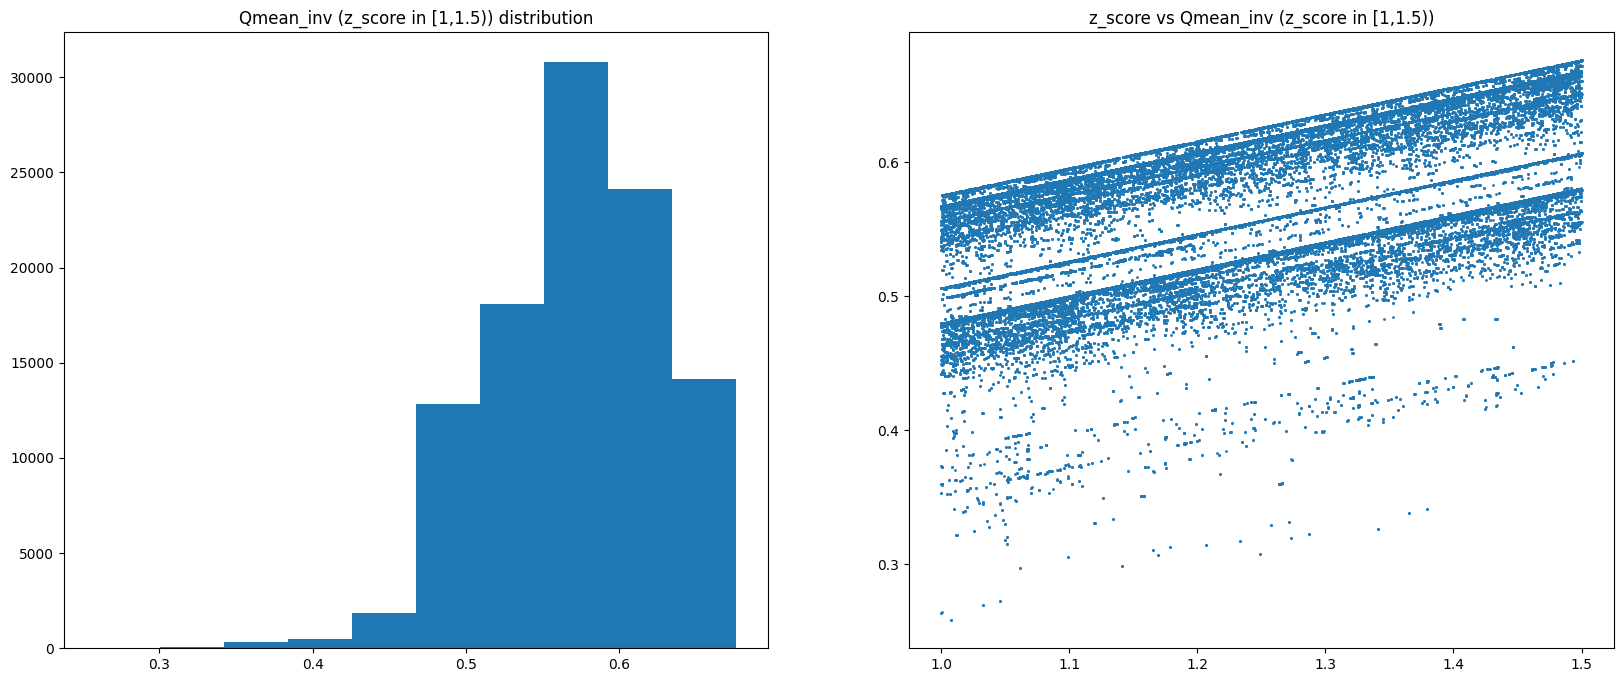

69295 elements with z_score in [1.5,2)
Pearson correlation z-score vs Qmean_inv (z_score in [1.5,2)):0.6388851432135437


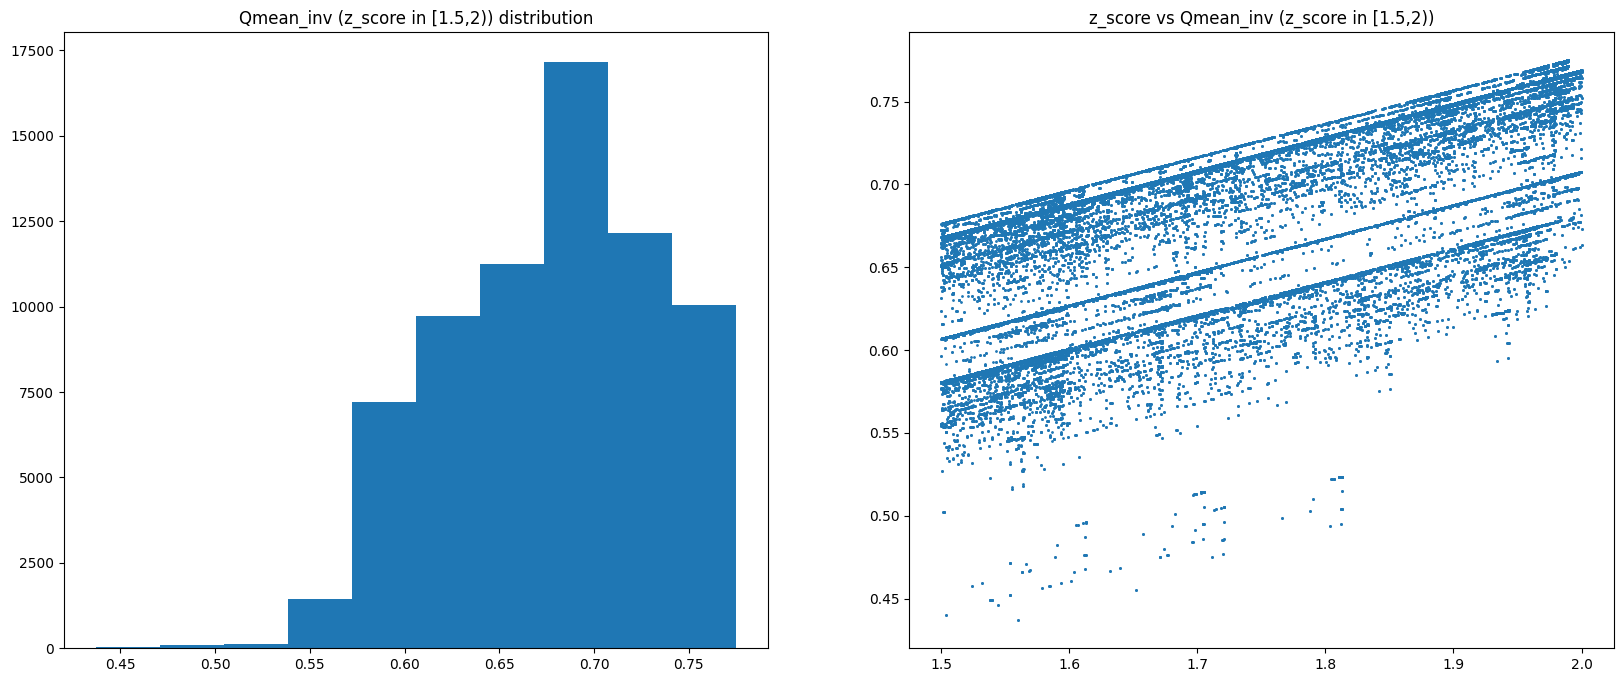

12866 elements with z_score in [2,inf)
Pearson correlation z-score vs Qmean_inv (z_score in [2,inf)):0.2750981723593599


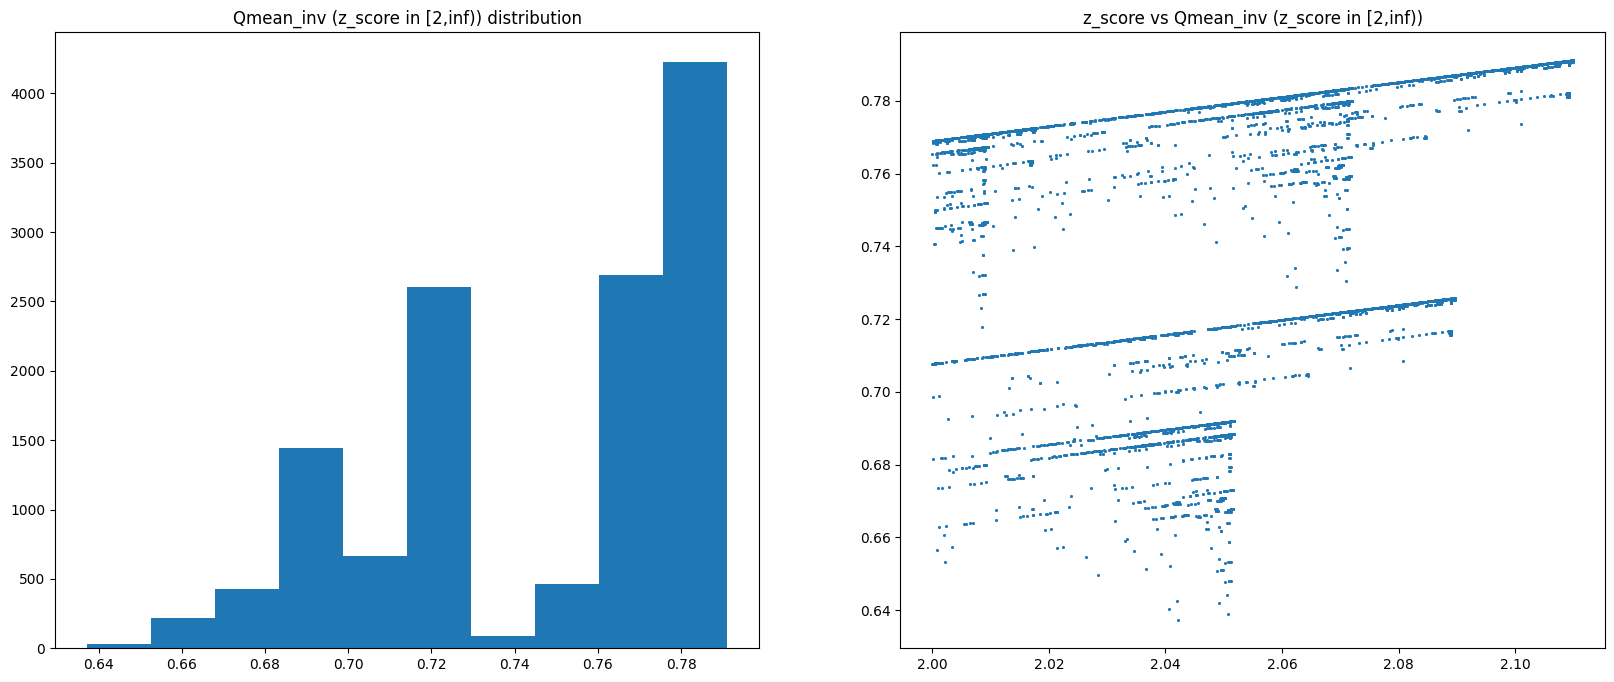

In [78]:
for indices, boundaries in level_indices:
    print(f'{indices.shape[0]} elements with z_score in [{boundaries[0]},{boundaries[1]})')
    show_performance(z_scores[indices], qmean_invs[indices], f'Qmean_inv (z_score in [{boundaries[0]},{boundaries[1]}))')

In [62]:
def attribution_to_ranking(attr):
    return list(map(lambda x:x[1], sorted(list(map(lambda x: (x[1],x[0]),enumerate(attr))))))

print(attribution_to_ranking(data['rankings'][np.argmax(data['faithfulness_correlations'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['monotonicity_correlations'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['qmeans'])]))
print(attribution_to_ranking(data['rankings'][np.argmax(data['qmean_invs'])]))

top10_faithfulness_correlations = np.argpartition(data['faithfulness_correlations'], -10)[-10:]
top10_monotonicity_correlations = np.argpartition(data['monotonicity_correlations'], -10)[-10:]
top10_qmeans = np.argpartition(data['qmeans'].flatten(), -10)[-10:]
top10_qmean_invs = np.argpartition(data['qmean_invs'].flatten(), -10)[-10:]
print(top10_faithfulness_correlations)
print(top10_monotonicity_correlations)
print(top10_qmeans)
print(top10_qmean_invs)

[1, 8, 0, 5, 7, 6, 9, 3, 4, 2]
[6, 5, 0, 8, 7, 1, 2, 3, 4, 9]
[0, 9, 3, 4, 8, 7, 6, 1, 2, 5]
[0, 9, 7, 3, 8, 4, 6, 1, 2, 5]
[760312 760536 760952 765278 402280 392338 750922 755200 761021 795524]
[920714 920696 910634 915674 910586 875330 870290 910610 910616 910730]
[274197 314277 314517 313437 273957 273117 274077 273119 313439 314397]
[273957 313677 314517 314277 274197 314397 273357 274077 313797 273477]
